In [1]:
import numpy as np
import random
from collections import OrderedDict
from functools import partial
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from torch.utils.data import random_split

import math
import json
from typing import Callable, Iterable, Tuple
from torch.optim import Optimizer

import wandb
wandb.login()
from pytorch_lightning.loggers import WandbLogger

import collections

wandb: Currently logged in as: chucooleg (use `wandb login --relogin` to force relogin)


In [2]:
## Code Depth 1

def construct_full_model(hparams):
    '''
    return: nn.Module. Take a sequence of input symbols and 
    return a sequence of output symbols
    '''

    # cloned
    clone = copy.deepcopy
    pff = Positiontwise_FF(d_model=hparams['d_model'], d_ff=hparams['d_ff'])
    attn = MultiHeadAttention(
        d_model=hparams['d_model'], 
        h=hparams['num_heads'], 
        attn_wt_dropout=hparams['attn_wt_dropout'],
    )
    layer_norm = LayerNorm(d_model=hparams['d_model'])

    # embeddings
    scaled_embed_X = ScaledEmbedding(hparams['vocab_size'], hparams['d_model'])
#     scaled_embed_query = ScaledEmbedding(hparams['vocab_size_query'], hparams['d_model'])
    # shared
    # position_encoder = PositionEncoder(
    #     d_model=hparams['d_model'], 
    #     max_len=hparams['max_len'], 
    #     emb_var=torch.var(scaled_embed.embedding.weight)
    # )
    position_encoder = LearnedPositionEncoder(
        d_model=hparams['d_model'], 
        max_len=hparams['max_len'],
        emb_init_var=torch.var(scaled_embed_X.embedding.weight).cpu().item()
    )
#     query_position_encoder = LearnedQueryPositionEncoder(
#         d_model=hparams['d_model'], 
#         max_len=hparams['max_len'], 
#         emb_init_var=torch.var(scaled_embed_X.embedding.weight).cpu().item()
#     )
    embed_dropout = nn.Dropout(hparams['embed_dropout'])

    # full model
    model = EncoderPredictor(
        encoder_querykey=Encoder(
            encoder_layer=EncoderLayer(
                poswise_ff=clone(pff),
                self_attn=clone(attn), 
                layer_norm=clone(layer_norm), 
                heads_dropout=hparams['heads_dropout'],
                pff_dropout=hparams['pff_dropout']
            ), 
            N_layers=hparams['N_enc'],
            d_model=hparams['d_model'],
        ),
#         encoder_key=Encoder(
#             encoder_layer=EncoderLayer(
#                 poswise_ff=clone(pff),
#                 self_attn=clone(attn), 
#                 layer_norm=clone(layer_norm), 
#                 heads_dropout=hparams['heads_dropout'],
#                 pff_dropout=hparams['pff_dropout']
#             ), 
#             N_layers=hparams['N_enc'],
#             d_model=hparams['d_model'],
#         ),
        classifier=Classifier(
            d_model=hparams['d_model']
        ),
        inp_querykey_layer=nn.Sequential(
            OrderedDict([('scaled_embed', scaled_embed_X),
                        ('position_encoder', position_encoder),
                        ('embed_dropout', embed_dropout)]
            )
        ),
#         inp_key_layer=nn.Sequential(
#             OrderedDict([('scaled_embed', scaled_embed_X),
#                         ('position_encoder', position_encoder),
#                         ('embed_dropout', embed_dropout)]
#             )
#         ),
        pad_idx_querykey=hparams['padding_idx_querykey'],
#         pad_idx_key=hparams['padding_idx_key']
        sep_idx_querykey=hparams['sep_idx_querykey']
    )

    return model

In [3]:
## Code Depth 2

class EncoderPredictor(nn.Module):

    def __init__(self, encoder_querykey, classifier, inp_querykey_layer, 
                 pad_idx_querykey, sep_idx_querykey):
        super(EncoderPredictor, self).__init__()
        self.encoder_querykey = encoder_querykey
#         self.encoder_key = encoder_key
        self.inp_querykey_layer = inp_querykey_layer
#         self.inp_key_layer = inp_key_layer
        self.pad_idx_querykey = pad_idx_querykey
        self.sep_idx_querykey = sep_idx_querykey
        self.classifier = classifier

    def forward(self, X_query, X_pos_key, X_neg_keys, debug=False):
        '''
        X_query: (b, inp_len)
        X_pos_key: (b, inp_len)
        X_neg_keys: (b, num negs, inp_len)
        '''
        
        b, num_negs, inp_len = X_neg_keys.shape 
        
        # shape(batch_size=b, 1, inp_len)
        X_query = X_query.unsqueeze(1)
        
        # shape(batch_size=b, 1, inp_len)
        X_pos_key =  X_pos_key.unsqueeze(1)
        
        # shape(batch_size=b, 1 + num negs, inp_len)
        X_keys = torch.cat((X_pos_key, X_neg_keys), dim=1)
        
        # shape(b, 1+num_negs, 1)
        seps = torch.ones(b, 1+num_negs, 1).type_as(X_query) * self.sep_idx_querykey
        
        # shape(batch_size=b, 1 + num negs, inp_len * 2 + 1)
        X_querykey = torch.cat((X_query.repeat(1, 1+num_negs, 1), seps, X_keys), dim=2)
        assert X_querykey.shape == (b, 1+num_negs, 2*inp_len + 1)

        # shape(batch_size=b, 1 + num negs, inp_len * 2 + 1)
        inp_querykey_pads = (X_querykey == self.pad_idx_querykey).int() 

        # shape(batch_size=b, 1 + num negs, d_model)
        encoder_out = self.encode_querykey(X_querykey, inp_querykey_pads)
        
        # shape (b, 1 + num negs)
        logits = self.classifier(encoder_out)

        return logits

    def encode_querykey(self, X, inp_pads):
        '''
        X: (batch_size=b, num pos(1) + num negs, inp_len)
        inp_pads: (batch_size=b, num pos(1) + num negs, inp_len)
        '''
        
        # NOTE: extract vector from inp_len th position 
        
        b, K, l = X.shape 
        X = X.reshape(b*K, l)
        inp_pads = inp_pads.reshape(b*K, l)
        
        # shape(b*K, inp_len, d_model)
        inp_embed = self.inp_querykey_layer(X)
        d_model = inp_embed.shape[-1]     
        
        # shape(b*K, N_enc, inp_len, d_model)
        encoder_out = self.encoder_querykey(inp_embed, inp_pads)        

        # shape (b, K, d_model)
        # inp_len position at <SEP>
        encoder_out = encoder_out[:, -1, 0, :].reshape(b, K, d_model)
#         encoder_out = encoder_out[:, -1, l//2, :].reshape(b, K, d_model)

        return encoder_out

In [4]:
## Code Depth 3
# http://karlstratos.com/notes/transformer17.pdf


class Encoder(nn.Module):

    def __init__(self, encoder_layer, N_layers, d_model):
        super(Encoder, self).__init__()
        self.encoder_layers = nn.ModuleList(
            [copy.deepcopy(encoder_layer) for _ in range(N_layers)])
        self.N_layers = N_layers
        self.d_model = d_model

    def forward(self, inp_embedding, inp_pads):
        """
        Args
        inp_embedding: Input embeddings. Already position encoded.
                        shape (batch_size=b, inp_len, d_model)
        inp_pads: Input pads. shape (batch_size=b, inp_len). 1s are padded.
        Returns
        encoder_out: output from encoder stack. 
                    shape (batch_size=b, inp_len, d_model)
        """
        m, inp_len, d_model = inp_embedding.shape

        # Make self-attn mask
        self_attn_mask = make_attn_mask(inp_pads, inp_pads, mask_forward=False)

        # Initiate encoder output tensor
        encoder_out = torch.empty(
            m, self.N_layers, inp_len, self.d_model).type_as(inp_embedding)

        # Loop through layers in stack
        last_z = inp_embedding
        for l, encoder_layer in enumerate(self.encoder_layers):
            # shape (b, inp_len, d_model)
            last_z, _ = encoder_layer(last_z, self_attn_mask)
#             print("encoder layer",l)
            encoder_out[:, l, :, :] = last_z

        # shape(b, N_enc, inp_len, d_model)
        return encoder_out


class Decoder(nn.Module):

    def __init__(self, decoder_layer, N_layers, d_model):
        super(Decoder, self).__init__()
        self.decoder_layers = nn.ModuleList(
            [copy.deepcopy(decoder_layer) for _ in range(N_layers)])
        self.N_layers = N_layers
        self.d_model = d_model

    def forward(self, encoder_out, out_embedding, 
                inp_pads, out_pads, max_decode=100):
        """
        Args
        encoder_out: output from encoder stack.
                    shape (batch_size=b, N_enc, inp_len, d_model)
        out_embedding: Output embedding. Shape (batch_size=b, out_len, d_model)
                    Already position encoded. Offset by one position.
        inp_pads: Input pads. shape (batch_size=b, inp_len). 1s are padded.
        out_pads: Input pads. shape (batch_size=b, out_len). 1s are padded.
        Returns
            decoder_out: output from decoder stack
        """
        # b, N_enc, inp_len, d_model = encoder_out.shape
        # b, out_len, d_model = out_embedding.shape

        self_attn_mask = make_attn_mask(out_pads, out_pads, mask_forward=True)
        cross_attn_mask = make_attn_mask(out_pads, inp_pads, mask_forward=False)

        # Loop through layers in stack
        last_o = out_embedding
        for l, decoder_layer in enumerate(self.decoder_layers):
            # shape (b, out_len, d_model)
            last_o, _, _ = decoder_layer(
                last_o, 
                # encoder_out[:, -1, :, :],
                encoder_out[:, l, :, :],
                self_attn_mask, cross_attn_mask
            )
        decoder_output = last_o
        return decoder_output

    
class Classifier(nn.Module):

    def __init__(self, d_model):
        super(Classifier, self).__init__()
        self.Wout = nn.Linear(d_model, 1)

    def forward(self, encoder_out):
        '''
        encoder_out: shape(batch_size=b, 1 + num negs, d_model)
        '''
        # shape (b, 1 + num negs, d_model) mm (d_model, 1) = (b, 1 + num negs, 1)
        # shape (b, 1 + num negs)
        logits = self.Wout(encoder_out).squeeze(-1)
        
        # # shape (b, 1 + num negs) too expensive to compute everytime
        # probs = torch.softmax(logits, dim=-1)
        return logits #, probs


class ScaledEmbedding(nn.Module):

    def __init__(self, V, d_model):
        super(ScaledEmbedding, self).__init__()
        self.embedding = nn.Embedding(V, d_model)
        # scale embedding to have variance 0.01
        nn.init.normal_(self.embedding.weight, mean=0., std=(0.01)**(1/2))
        self.d_model = d_model

    def forward(self, tokens):
        '''
        tokens: shape (batch_size=b, len)
        '''
        # shape (b, len, d_model)
        embedded = self.embedding(tokens) * math.sqrt(self.d_model)
        if torch.max(embedded) > 2000.:
            import pdb; pdb.set_trace()
        return embedded

    
class PositionEncoder(nn.Module):
    # Alternative implementation
    # https://github.com/jalammar/jalammar.github.io/blob/master/notebookes/transformer/transformer_positional_encoding_graph.ipynb

    def __init__(self, d_model, max_len):
        super(PositionEncoder, self).__init__()
        # even
        # i = 0, 2, 4, 6, ..., 510
        # j = 0, 1, 2, 3, ..., 255
        # PE(pos, i=2j) = sin(pos/10000**(2*j/d_model))
        # odd
        # i = 1, 3, 5, 7, ..., 511
        # j = 0, 1, 2, 3, ..., 255
        # PE(pos, i=2j+1) = cos(pos/10000**(2*j/d_model))
        # shape(256,)
        self.d_model = d_model
        self.max_len = max_len
        self.register_buffer(
            name="positional_encoding", 
            tensor=self.make_encodings(self.d_model, self.max_len)
        )

    @staticmethod
    def make_encodings(d_model, max_len):
        # shape (d_model/2)
        div_terms = torch.pow(
            10000, 
            2*torch.arange(start=0, # j = 0
                       end=d_model/2 # j = 255
            )/d_model
        )

        # shape (max_len,) -> shape (max_len, d_model)
        positions = torch.arange(
            max_len
            ).unsqueeze(-1).expand(-1, d_model)

        # shape (max_len, d_model)
        positional_encoding = torch.empty(
            max_len, d_model, dtype=torch.float, 
        )
    
        # shape (max_len, d_model/2)
        pos_at_even_dims = positions[:, ::2]
        # shape (max_len, d_model/2)
        pos_at_odd_dims  = positions[:, 1::2]

        # shape (max_len, d_model/2)
        div_terms_expand = div_terms.unsqueeze(0).expand(max_len, -1)

        # shape (max_len, d_model/2)
        positional_encoding[:, ::2] = torch.sin(pos_at_even_dims / div_terms_expand)
        # shape (max_len, d_model/2)
        positional_encoding[:, 1::2] = torch.cos(pos_at_odd_dims / div_terms_expand)

        # shape (max_len, d_model)
        return positional_encoding

    def forward(self, embedded):
        '''
        embedded: shape (batch_size=b, len, d_model)
        '''
        b, len, d_model = embedded.shape
        assert len <= self.max_len
        # shape (batch_size=b, len, d_model)
        positional_encoding = (
            self.positional_encoding[:len, :].unsqueeze(0).expand(b, -1, -1)
        )
        # shape (batch_size=b, len, d_model)
        return positional_encoding + embedded


class LearnedPositionEncoder(nn.Module):
    '''Learned, instead of sinusoidal position encoder'''

    def __init__(self, d_model, max_len, emb_init_var):
        super().__init__()
        self.pos_embedding = nn.Parameter(
            torch.nn.init.normal_(
                torch.zeros(max_len, d_model), 
                mean=0.0, 
#                 std=1.0,
#                 std=(emb_init_var)**(0.5)
                std=(emb_init_var/2)**(0.5)
        ))

    def forward(self, embedded):
        '''
        embedded: shape (batch_size=b, len, d_model)
        '''
        b, inp_len, d_model = embedded.shape
        # shape (1, len, d_model)
        pos_embeddings = self.pos_embedding[:inp_len, :].unsqueeze(0)
        
        # use broadcasting
        # shape (b, len, d_model)
        return embedded + pos_embeddings


class LearnedScenePositionEncoder(nn.Module):
    '''Learned position encoder for scene. Each position i,j is concat of encoding_i and encoding_j'''
    def __init__(self, d_model, grid_dim, emb_init_var):
        super().__init__()
        self.d_model = d_model
        self.grid_dim = grid_dim
        self.emb_init_var = emb_init_var
        
        self.pos_embedding_i = nn.Parameter(
            torch.nn.init.normal_(
                torch.zeros(grid_dim, d_model/2), 
                mean=0.0, 
                std=(emb_init_var/2)**(0.5)
            ).unsqueeze(1)
        )
        self.pos_embedding_j = nn.Parameter(
            torch.nn.init.normal_(
                torch.zeros(grid_dim, d_model/2), 
                mean=0.0, 
                std=(emb_init_var/2)**(0.5)
            ).unsqueeze(0)
        )
        
    def make_embedding_ij(self):
        pos_embedding_ij = torch.cat(
            (
                self.pos_embedding_i.expand(
                    self.pos_embedding_i.shape[0],
                    self.grid_dim,
                    self.pos_embedding_i.shape[1]
                ),
                self.pos_embedding_j.expand(
                    self.grid_dim,
                    self.pos_embedding_j.shape[0],
                    self.pos_embedding_j.shape[1]
                )
            ),
            dim=-1
        )
        assert pos_embedding_ij.shape == (self.grid_dim, self.grid_dim, self.d_model)
        # shape (grid_dim**2, d_model)
        # order(0,0),(0,1),(0,2),(1,0),(1,1),(1,2),(2,0),(2,1),(2,2)
        return pos_embedding_ij.view(-1, self.d_model)
        
    def forward(self, embedded):
        '''
        embedded: shape (batch_size=b, grid_dim**2, d_model)
        '''
        b, inp_len, d_model = embedded.shape
        # shape (1, len=grid_dim**2, d_model)
        pos_embeddings = self.make_embedding_ij().unsqueeze(0)
        # use broadcasting
        # shape (b, len=grid_dim**2, d_model)
        return embedded + pos_embeddings        

(1, 50, 512)


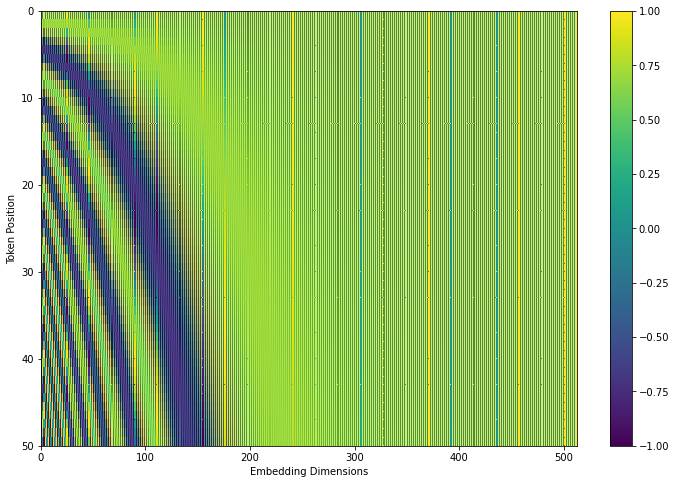

In [5]:
# Testing positional encoder

def test_positional_encoder(PositionEncoder, max_len=10, d_model=64):
    # test positional encoding
    b, len, d_model = 20, max_len, d_model
    embedding = torch.randn(b, len, d_model)
    pos_enc = PositionEncoder(d_model, 50)
    positional_encoding = pos_enc.positional_encoding
    plot_positional_encoding(positional_encoding)

def plot_positional_encoding(positional_encoding):
    '''
    positional_encoding: tensor shape (len, d_model)
    '''

    tokens, dimensions = positional_encoding.shape
  
    pos_encoding = positional_encoding.unsqueeze(0).cpu().numpy()

    print (pos_encoding.shape)

    plt.figure(figsize=(12,8))
    plt.pcolormesh(pos_encoding[0], cmap='viridis')
    plt.xlabel('Embedding Dimensions')
    plt.xlim((0, dimensions))
    plt.ylim((tokens,0))
    plt.ylabel('Token Position')
    plt.colorbar()
    plt.show()

test_positional_encoder(PositionEncoder, d_model=512)

In [6]:
## Code Depth 4
# http://karlstratos.com/notes/transformer17.pdf


class EncoderLayer(nn.Module):
    '''
    single layer encoder
    '''
    def __init__(self, poswise_ff, self_attn, layer_norm,
                heads_dropout, pff_dropout):
        super(EncoderLayer, self).__init__()
        self.poswise_ff = poswise_ff
        self.self_attn = self_attn
        self.layer_norms = nn.ModuleList([copy.deepcopy(layer_norm) for _ in range(2)])
        self.heads_dropout = nn.Dropout(heads_dropout)
        self.pff_dropout = nn.Dropout(pff_dropout)

    def forward(self, z_lm1, self_attn_mask):
        '''
        z_lm1 : last encoder layer activations. shape (batch_size=b, inp_len, d_model)
        '''

        # (b, inp_len, d_model)
        z_lm1_h, self_attn_wts = self.self_attn(z_lm1, z_lm1, self_attn_mask)
        # (b, inp_len, d_model)
        z_lm1_h_norm = self.layer_norms[0](z_lm1 + self.heads_dropout(z_lm1_h))
        # (b, inp_len, d_model)
        z_lm1_ff = self.poswise_ff(z_lm1_h_norm)
        # (b, inp_len, d_model)
        z_l = self.layer_norms[1](z_lm1_h_norm + self.pff_dropout(z_lm1_ff))
        
        if torch.isinf(z_l).any() or torch.isnan(z_l).any():
            print("z_l is nan or inf")
            import pdb; pdb.set_trace()
        
        return z_l, self_attn_wts


class DecoderLayer(nn.Module):
    '''
    single layer decoder
    '''
    def __init__(self, poswise_ff, self_attn, cross_attn, 
                layer_norm, heads_dropout, pff_dropout):
        super(DecoderLayer, self).__init__()
        self.poswise_ff = poswise_ff
        self.self_attn = self_attn
        self.cross_attn = cross_attn
        self.layer_norms = nn.ModuleList([copy.deepcopy(layer_norm) for _ in range(3)])
        self.heads_dropout = nn.Dropout(heads_dropout)
        self.pff_dropout = nn.Dropout(pff_dropout)

    def forward(self, o_lm1, encoder_l_output, self_attn_mask, cross_attn_mask):
        '''
        o_lm1 : last decoder layer activations. 
            shape (batch_size=b, out_len, d_model).
        encoder_l_output : encoder output from at the same layer index. 
                       shape (batch_size=b, inp_len, d_model)
        '''

        # (b, out_len, d_model)
        o_lm1_self_h, self_attn_wts = self.self_attn(o_lm1, o_lm1, self_attn_mask)
        # (b, out_len, d_model)
        o_lm1_self_h_norm = self.layer_norms[0](o_lm1 + self.heads_dropout(o_lm1_self_h))
        # (b, out_len, d_model)
        o_lm1_cross_h, cross_attn_wts = self.cross_attn(o_lm1_self_h_norm, encoder_l_output, cross_attn_mask)
        # (b, out_len, d_model)
        o_lm1_cross_h_norm = self.layer_norms[1](o_lm1_self_h_norm + self.heads_dropout(o_lm1_cross_h))
        # (b, out_len, d_model)
        o_lm1_ff = self.poswise_ff(o_lm1_cross_h_norm)
        # (b, out_len, d_model)
        o_l = self.layer_norms[2](o_lm1_cross_h_norm + self.pff_dropout(o_lm1_ff))
        return o_l, self_attn_wts, cross_attn_wts

In [7]:
## Code Depth 5
# https://arxiv.org/pdf/1607.06450.pdf


class LayerNorm(nn.Module):
    '''Layer Normalization'''

    def __init__(self, d_model, epsilon=1e-6):
        super(LayerNorm, self).__init__()
        self.gain = nn.Parameter(torch.ones(d_model))
        self.bias = nn.Parameter(torch.zeros(d_model))
        self.epsilon = epsilon

    def forward(self, x):
        '''
        Args:
            x : shape (m, len, d_model)
        Returns:
            whitened_x : shape (m, len, d_model)
        '''
        # (m, len, 1)
        mu = torch.mean(x, dim=-1, keepdim=True)
        std = torch.std(x, dim=-1, keepdim=True)
        # (m, len, d_model)
        whitened_x = self.gain * (x - mu / (std + self.epsilon)) + self.bias
        return whitened_x


class Positiontwise_FF(nn.Module):
    '''Pointwise FeedForward / Fat-RELU'''

    def __init__(self, d_model, d_ff):
        super(Positiontwise_FF, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
  
    def forward(self, x):
        '''
        Args:
            x : shape (m, len, d_model)
        Returns:
            shape (m, len, d_model)
        '''
        return self.linear2(F.relu(self.linear1(x)))


class MultiHeadAttention(nn.Module):
    '''Multihead Attention'''

    def __init__(self, d_model, h, attn_wt_dropout):
        super(MultiHeadAttention, self).__init__()
        self.h = h
        self.d_model = d_model
        # d_k, same as d_q, d_v
        self.d_k = int(d_model / h)
        

        ############################################################
        # simply use clone
    
#         # shape (d_model, d_k * h = d_model)
#         projection = nn.Linear(d_model, d_model, bias=True)
#         # clone projection to become WQ, WK, WV, WO
#         self.projections_QKVO = nn.ModuleList([copy.deepcopy(projection) for _ in range(4)])
        ############################################################
#         # Untie only WQ

#         # template for WQ, WK, WV, WO projection matrices
#         # shape (d_model, d_k * h = d_model)
#         make_projection = lambda: nn.Linear(d_model, d_model, bias=True)

#         # shape (d_model, d_k * h = d_model)
#         shared_projection = make_projection()

#         # WQ independent, WKVO shared
#         projections = (
#             [make_projection()] + [copy.deepcopy(shared_projection) for _ in range(3)]
#         )
#         self.projections_QKVO = nn.ModuleList(projections)

        ############################################################
        # Untie WQ, WK, WV, WO
        
        # template for WQ, WK, WV, WO projection matrices
        # shape (d_model, d_k * h = d_model)
        make_projection = lambda: nn.Linear(d_model, d_model, bias=True)
        # make WQ, WK, WV, WO
        self.projections_QKVO = nn.ModuleList([make_projection() for _ in range(4)])
        ############################################################
       # initialize WO as zeros to start training w/ identity function
        self.projections_QKVO[3].weight.data = self.projections_QKVO[3].weight.data * 0.0
        self.projections_QKVO[3].bias.data = self.projections_QKVO[3].bias.data * 0.0
        ############################################################       
        
        self.attn_wt_dropout = nn.Dropout(p=attn_wt_dropout)
        

    def forward(self, X, Y, mask):
        '''
        Args:
            X : Attender. shape (batch_size=b, attender len=n, d_model)
            Y : Attendee. shape (batch_size=b, attendee len=m, d_model)
        Return:
            attn_V : shape (b, n, h*d_k=d_model)
        '''
        b, n, d_model = X.shape

        # Project X and Y to Q, K, V matrices
        # Step 1 W(vals)
        # XQ shape(b, n, d_k *h = d_model)
        # YK shape(b, m, d_k *h = d_model)
        # YV shape(b, m, d_k *h = d_model)
        # Step 2 reshape()
        # XQ shape(b, n, h, d_k)
        # YK shape(b, m, h, d_k)
        # YV shape(b, m, h, d_k)
        # Step 3 swap axis with transpose()
        # XQ shape(b, h, n, d_k)
        # YK shape(b, h, m, d_k)
        # YV shape(b, h, m, d_k)
        XQ, YK, YV = [
                      W(vals).reshape(b, -1, self.h, self.d_k)
                      .transpose(1, 2) 
                      for (W, vals) in zip(self.projections_QKVO[:3], (X, Y, Y))]

        # attention weighted values, attention weights
        # shape (b, n, h, d_k), (b, h, n, m)
        concat_V, attn = dotproduct_attention(
            XQ, YK, YV, mask, self.attn_wt_dropout)
        # shape (b, n, h*d_k=d_model)
        concat_V = concat_V.reshape(b, n, -1)

        # project by WO, shape (b, n, h*d_k=d_model)
        attn_V = self.projections_QKVO[3](concat_V)
   
        return attn_V, attn

In [8]:
## Code Depth 6

def dotproduct_attention(Q, K, V, mask, beta_dropout, debug=False):
    '''
    Q: shape(batch_size=b, num heads=h, attender len=n, d_k)
    K: shape(batch_size=b, num heads=h, attendee len=m, d_k)
    V: shape(batch_size=b, num heads=h, attendee len=m, d_k)
    mask: shape(batch_size=b, n, m)
    beta_dropout: nn.Dropout().apply module
    '''
    b, h, n, d_k = Q.shape
    b, h, m, d_k = K.shape

    # XQ shape(b, h, n, d_k) matmul YK.T shape(b, h, d_k, m)
    # = alpha shape (b, h, n, m)
    alpha = torch.matmul(Q, K.transpose(-1, -2))/ math.sqrt(d_k)

    # Apply mask 
    # (b, h, n, m)
    mask_stack = mask.unsqueeze(1).expand(-1, h, -1, -1)
    alpha_masked = torch.masked_fill(alpha, mask_stack==1, -1e4)

    # normalize across attendee len m
    # (b, h, n, m)
    beta = beta_dropout(torch.softmax(alpha_masked, dim=-1))

    # beta shape(b, h, n, m) bmm YK.T shape(b, h, m, d_k) = shape (b, h, n, d_k)
    # transpose to (b, n, h, d_k)
    wt_V = torch.matmul(beta, V).transpose(1, 2)

    if debug:
        print('alpha\n', alpha)
        print('mask_stack\n', mask_stack)
        print('alpha_masked\n', alpha_masked)
        print('beta\n', beta)
        print('wt_V\n', wt_V)
        
    return wt_V, beta


def ref_attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 1, -1e9)
    p_attn = torch.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn


def test_attention(attn_fn):
    torch.manual_seed(123)
    b, h, n, m, d_k = 1, 2, 3, 3, 5
    Q = torch.randn(b, h, n, d_k)
    K = torch.randn(b, h, m, d_k)
    V = torch.randn(b, h, m, d_k)

    # print('Q\n', Q)
    # print('K\n', K)
    # print('V\n', V)

    mask = torch.zeros((b, n, m))
    mask[:,:,1] = 1
    mask[:,2,:1] = 1
    print('input', mask)

    my_wt_V = dotproduct_attention(Q, K, V, mask, nn.Dropout(0.0), debug=True)
    ref_wt_V, ref_p_attn = ref_attention(Q, K, V, mask, nn.Dropout(0.0))
  
    print('ref wt_V\n', ref_wt_V.transpose(1, 2))
    print('ref wt_V\n', ref_wt_V.shape)

test_attention(dotproduct_attention)

input tensor([[[0., 1., 0.],
         [0., 1., 0.],
         [1., 1., 0.]]])
alpha
 tensor([[[[-1.0231,  0.0260,  0.2767],
          [ 0.7859,  0.2193,  0.9244],
          [-0.5686,  1.7561,  1.9875]],

         [[-0.5513, -0.7215,  0.3740],
          [ 0.9782,  1.1411, -0.4604],
          [-0.0315,  0.7704, -0.9848]]]])
mask_stack
 tensor([[[[0., 1., 0.],
          [0., 1., 0.],
          [1., 1., 0.]],

         [[0., 1., 0.],
          [0., 1., 0.],
          [1., 1., 0.]]]])
alpha_masked
 tensor([[[[-1.0231e+00, -1.0000e+04,  2.7667e-01],
          [ 7.8594e-01, -1.0000e+04,  9.2435e-01],
          [-1.0000e+04, -1.0000e+04,  1.9875e+00]],

         [[-5.5126e-01, -1.0000e+04,  3.7404e-01],
          [ 9.7823e-01, -1.0000e+04, -4.6042e-01],
          [-1.0000e+04, -1.0000e+04, -9.8484e-01]]]])
beta
 tensor([[[[0.2142, 0.0000, 0.7858],
          [0.4655, 0.0000, 0.5345],
          [0.0000, 0.0000, 1.0000]],

         [[0.2839, 0.0000, 0.7161],
          [0.8082, 0.0000, 0.1918],
   

In [9]:
def make_attn_mask(attender_pads, attendee_pads, mask_forward=False, debug=False):
    '''
    Mask away attendee positions from attender.
    Args:
        attender_pads: shape(batch_size=b, attender len=n). 1s are pads.
        attendee_pads: shape(batch_size=b, attender len=m). 1s are pads.
    Return:
        attn_mask: shape(b, n, m)
    '''

    b, n = attender_pads.shape
    b, m = attendee_pads.shape

    if mask_forward: 
        assert n == m
        # shape (n, m)
        try:
            future_mask = torch.from_numpy(
                np.triu(np.ones((n, m)), k=1)).type_as(attender_pads)
        except:
            import pdb; pdb.set_trace()
        # shape (b, n, m)
        future_mask_expanded = future_mask.unsqueeze(0).expand(b, -1, -1)

    # shape(b, n, m)
    attender_mask_expanded = attender_pads.unsqueeze(-1).expand(-1, -1, m)
    # shape(b, n, m)
    attendee_mask_expanded = attendee_pads.unsqueeze(1).expand(-1, n, -1)

    # shape(b, n, m)
    if mask_forward: 
        sum_mask = attender_mask_expanded + attendee_mask_expanded + future_mask
    else:
        sum_mask = attender_mask_expanded + attendee_mask_expanded
    sum_mask = (sum_mask > 0).type(torch.int)

    if debug:
        if mask_forward:
            print('future_mask\n',future_mask)
        print('attender_mask_expanded\n',attender_mask_expanded)
        print('attendee_mask_expanded\n',attendee_mask_expanded)
        print('sum mask\n', sum_mask)

    return sum_mask


def test_make_attn_mask():
    #   attender_pads = torch.tensor([[0,0,0,1,1], [0,0,1,1,1], [0,0,0,0,0]])
    attender_pads = torch.tensor([[0,0,0,1], [0,0,0,0], [0,0,0,1]])
    attendee_pads = torch.tensor([[0,0,0,1], [0,0,0,0], [0,0,0,1]])
    print('Cross Attention:')
    make_attn_mask(attender_pads, attendee_pads, mask_forward=False, debug=True)
    print('--------------------------------------')
    print('Self Attention:')
    make_attn_mask(attender_pads, attender_pads, mask_forward=True, debug=True)


test_make_attn_mask()

Cross Attention:
attender_mask_expanded
 tensor([[[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [1, 1, 1, 1]],

        [[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]],

        [[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [1, 1, 1, 1]]])
attendee_mask_expanded
 tensor([[[0, 0, 0, 1],
         [0, 0, 0, 1],
         [0, 0, 0, 1],
         [0, 0, 0, 1]],

        [[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]],

        [[0, 0, 0, 1],
         [0, 0, 0, 1],
         [0, 0, 0, 1],
         [0, 0, 0, 1]]])
sum mask
 tensor([[[0, 0, 0, 1],
         [0, 0, 0, 1],
         [0, 0, 0, 1],
         [1, 1, 1, 1]],

        [[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]],

        [[0, 0, 0, 1],
         [0, 0, 0, 1],
         [0, 0, 0, 1],
         [1, 1, 1, 1]]], dtype=torch.int32)
--------------------------------------
Self Attention:
futur

In [10]:
class LabelSmoothedLoss(nn.Module):
    '''
    KL divergence Loss with Label Smoothing and Temperature scaling
    '''

#     def __init__(self, K, padding_idx, smoothing_const=0.0, temperature_const=1.0):
    def __init__(self, K, smoothing_const=0.0, temperature_const=1.0):
        super(LabelSmoothedLoss, self).__init__()
        self.smoothing_const = smoothing_const
        self.temperature_const = temperature_const
        self.K = K
#         self.padding_idx = padding_idx
        self.KLdiv_criterion = nn.KLDivLoss(reduction='sum')
        self.logprob = nn.LogSoftmax(dim=-1)


    def forward(self, logits, labels, debug=False):
        '''
        logits: shape (batch_size=b, 1 + num_negatives)
        labels: shape (batch_size=b,)
        '''
        b, K = logits.shape

        # Temperature Scaling
        # shape (b, K)
        scaled_logits = logits / self.temperature_const
        pred_logprobs = self.logprob(scaled_logits)

        # Expand Labels to one-hot, Smooth the values
        gt_probs_smoothed = torch.full(
            size=(b, K), 
            # fill_value=self.smoothing_const / (K - 1), # more mathematicaly correct
            fill_value=self.smoothing_const / (K - 1) #minus true
            # fill_value=self.smoothing_const / (K - 2) #minus true and padding
        ).type_as(logits)

        gt_probs_smoothed = gt_probs_smoothed.scatter(
            dim=-1, 
            index=labels.reshape(-1, 1), 
            value=(1. - self.smoothing_const),
            # value=(1. - self.smoothing_const) + (self.smoothing_const / (K - 1)) # more mathematicaly correct
        )
        
#         # Zero out padding idx
#         # shape (b, K)
#         gt_probs_smoothed[:, self.padding_idx] = 0.
    
#         # Apply mask (e.g. if end of context is padded)
#         # shape (b, 1)
#         mask_ctx_pos = torch.nonzero(torch.flatten(labels) == self.padding_idx)
#         if mask_ctx_pos.dim() > 0:
#             # zero out rows for padded context positions
#             # e.g. word at position 10 is a pad, we zero out all probs for row 10
#             gt_probs_smoothed.index_fill_(
#                 dim=0, index=mask_ctx_pos.squeeze(), value=0.0)

        if debug:
            print(scaled_logits)
            print(labels_onehot)
            print(mask_ctx_pos)
        
        try:
            assert torch.all(
                torch.logical_or(
                    torch.logical_and(
                        # sum of probs == 1
                        # torch.greater(torch.sum(gt_probs_smoothed, dim=-1), 0.999),
                        # torch.less(torch.sum(gt_probs_smoothed, dim=-1), 1.001) 
                        torch.all(torch.sum(gt_probs_smoothed, dim=-1) > 0.999),
                        torch.all(torch.sum(gt_probs_smoothed, dim=-1) < 1.001) 
                    ),
                    # except padded positions in context
                    torch.eq(torch.sum(gt_probs_smoothed, dim=-1), 0.)
                )
            )
        except:
            import pdb; pdb.set_trace()

        return self.KLdiv_criterion(input=pred_logprobs, target=gt_probs_smoothed)


# Only Use for verification
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
#     def __init__(self, size, padding_idx, smoothing=0.0):
    def __init__(self, size, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
#         self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
#         true_dist[:, self.padding_idx] = 0
#         mask = torch.nonzero(target.data == self.padding_idx)
#         if mask.dim() > 0:
#             true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))


def test_loss_function(myLoss, refLoss, smoothing_const, temperature_const):
    K = 3
    padding_idx = 2

    torch.manual_seed(123)
    myKL = myLoss(K, smoothing_const, temperature_const)
    refKL = refLoss(K, smoothing_const)

    labels = torch.tensor([1, 1, 1, 0, 1])
    inputs = torch.randn(5, 3) * 4
    print(inputs)

    ref_loss = refKL(F.log_softmax(inputs, dim=-1).reshape(-1, 3), torch.flatten(labels))
    my_loss = myKL(inputs, labels )
    #   if temperature_const == 1.0:
    #     assert ref_loss == my_loss
    print(ref_loss)
    print(my_loss)

# test_loss_function(myLoss=LabelSmoothedLoss, refLoss=LabelSmoothing, smoothing_const=0.1, temperature_const=1.0)

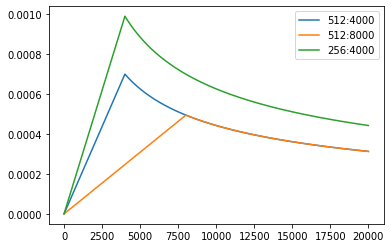

In [11]:
class LRScheduledAdam(Optimizer):
    """
    Implements Adam algorithm with learning rate schedule.
    Modified based on hugging face implementation:
    https://huggingface.co/transformers/_modules/transformers/optimization.html#AdamW

    Parameters:
        params (:obj:`Iterable[torch.nn.parameter.Parameter]`):
            Iterable of parameters to optimize or dictionaries defining parameter groups.
        d_model (:obj:`int`):
            Dimension of embedding vector.
        warmup_steps (:obj:`int`):
            Steps for warmup before learning rate peaks.
        lr (:obj:`float`, `optional`, defaults to 0.):
            The learning rate to use.
        betas (:obj:`Tuple[float,float]`, `optional`, defaults to (0.9, 0.999)):
            Adam's betas parameters (b1, b2).
        eps (:obj:`float`, `optional`, defaults to 1e-6):
            Adam's epsilon for numerical stability.
        weight_decay (:obj:`float`, `optional`, defaults to 0):
            Decoupled weight decay to apply.
        correct_bias (:obj:`bool`, `optional`, defaults to `True`):
            Whether ot not to correct bias in Adam (for instance, in Bert TF repository they use :obj:`False`).
    """

    def __init__(
        self,
        params: Iterable[torch.nn.parameter.Parameter],
        d_model: int,
        warmup_steps: int,
        lr: float = 0.,
        betas: Tuple[float, float] = (0.9, 0.98),
        eps: float = 1e-9,
        correct_bias: bool = True,
    ):
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {} - should be >= 0.0".format(lr))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter: {} - should be in [0.0, 1.0[".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter: {} - should be in [0.0, 1.0[".format(betas[1]))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {} - should be >= 0.0".format(eps))
        defaults = dict(
            lr=lr, betas=betas, eps=eps, correct_bias=correct_bias)
        super().__init__(params, defaults)
        self.d_model = d_model
        self.warmup_steps = warmup_steps

    def calc_step_size(self, step_num):
        '''udpate lr'''
        return (
            self.d_model**(-0.5) * min(step_num**(-0.5), step_num * self.warmup_steps**(-1.5))
        )

    def step(self, closure: Callable = None):
        """
        Performs a single optimization step.

        Arguments:
            closure (:obj:`Callable`, `optional`): A closure that reevaluates the model and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError("Adam does not support sparse gradients, please consider SparseAdam instead")

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state["step"] = 0
                    # Exponential moving average of gradient values
                    state["exp_avg"] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state["exp_avg_sq"] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state["exp_avg"], state["exp_avg_sq"]
                beta1, beta2 = group["betas"]

                state["step"] += 1

                # Decay the first and second moment running average coefficient
                # In-place operations to update the averages at the same time
                exp_avg.mul_(beta1).add_(grad, alpha=1.0 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1.0 - beta2)
                denom = exp_avg_sq.sqrt().add_(group["eps"])

                group["lr"] = self.calc_step_size(state["step"])
                step_size = group["lr"]
                if group["correct_bias"]:  # No bias correction for Bert
                    bias_correction1 = 1.0 - beta1 ** state["step"]
                    bias_correction2 = 1.0 - beta2 ** state["step"]
                    step_size = step_size * math.sqrt(bias_correction2) / bias_correction1

                p.data.addcdiv_(exp_avg, denom, value=-step_size)
        return loss

def plot_lr(myOpt):
    model = nn.Linear(2,3)
    opts = [myOpt(model.parameters(), 512, 4000), 
            myOpt(model.parameters(), 512, 8000),
            myOpt(model.parameters(), 256, 4000)]
    plt.plot(np.arange(1, 20000), [[opt.calc_step_size(i) for opt in opts] for i in range(1, 20000)])
    plt.legend(["512:4000", "512:8000", "256:4000"])

plot_lr(LRScheduledAdam)

In [12]:
def greedy_decode_sequence(model, X, start_idx_Y, pad_idx_X, pad_idx_Y, max_len):
    '''
    Greedy Decoding
    X : a sequence of input symbols. shape(batch_size=b, inp_len)
    start_idx_Y: int.
    pad_idx_X: int.
    pad_idx_Y: int.
    max_len: int. Maximum context length for generation. Include <SOS> and <EOS>
    '''

    b, inp_len = X.shape
    inp_pads = (X == pad_idx_X).int()

    # encode inputs
    # shape (b, inp_len, d_model)
    encoded_memory = model.encode(X, inp_pads)
 
    # shape (b, max_len) e.g. (b, 10)
    Y = torch.ones(b, max_len).type_as(X) * pad_idx_Y
    Y[:,0] = start_idx_Y
    # shape (b, max_len)
    out_pads = (Y == pad_idx_Y).int()
  
    # generate one token at a time
    for t in range(1, max_len): # (1 to 9)

        # shape (b, t, d_model)
        decoder_output = model.decode(encoded_memory, Y[:, :t], inp_pads, out_pads[:, :t])

        # shape (b, t, V)
        decoded_logits = model.classifier(decoder_output)
        # decoded_probs = torch.softmax(decoded_logits, dim=-1)
    
        # shape (b,), (b,)
        max_prob, max_idx = torch.max(decoded_logits[:, -1, :], dim=-1)
    
        # update Y, out_pads for next timestep
        Y[:, t] = max_idx
        out_pads[:, t] = (max_idx == pad_idx_Y).int()

    # shape (b, max_len)
    # (1 to 9)
    return Y[:, 1:]

In [13]:
def multiclass_accuracy(start_idx_Y, pad_idx_Y, pred, labels):
    '''
    pred: shape (batch_size, max_len)
    labels: shape (batch_size, max_len) 
    '''
    assert not start_idx_Y in labels, '<GO> should not be evaluated'

    mask = 1 - (labels == pad_idx_Y).int() # 0 means padded
    tot_not_masked = torch.sum(mask)

    same = (pred == labels).int() * mask
    tot_correct = torch.sum(same)

    return tot_correct * 1.0 / tot_not_masked

# 4/6
multiclass_accuracy(1, 0, torch.tensor([[2,2,0,0],[7,8,7,0]]), torch.tensor([[2,2,0,4],[7,8,9,0]]))

tensor(0.6667)

In [14]:
# Build Lightning Module
# https://colab.research.google.com/drive/1F_RNcHzTfFuQf-LeKvSlud6x7jXYkG31#scrollTo=UIXLW8CO-W8w

class Transformer(pl.LightningModule):
    
    def __init__(self, hparams):
        super(Transformer, self).__init__()
        self.hparams = hparams
        self.model = construct_full_model(hparams)
        
        self.loss_criterion = LabelSmoothedLoss(
            K= 1 + hparams['num_negatives'], # num positive queries + num negative queries
            smoothing_const=hparams['smoothing_const'],
            temperature_const=hparams['temperature_const']
        )
#         self.loss_criterion = nn.CrossEntropyLoss(reduction='sum')

    def accuracy(self, logits):
        '''logits shape: # shape (b, num pos keys + num neg keys)'''
        return torch.mean((torch.max(logits, dim=-1)[1] == 0).type_as(logits))
    
    def log_metrics(self, metrics_dict):
        for k, v in metrics_dict.items():
            self.log(k, v)

    def get_max_memory_alloc(self):
        devices_max_memory_alloc = {}
        for i in range(torch.cuda.device_count()):
            device = torch.device(f'cuda:{i}')
            devices_max_memory_alloc[device] = torch.cuda.max_memory_allocated(device) / 1e6
            torch.cuda.reset_max_memory_allocated(device)
        return devices_max_memory_alloc
    
    def forward(self, X_query, X_pos_key, X_neg_keys, debug=False):
        batch_size = X_query.shape[0]
        # shape (b, num pos keys + num neg keys)
        logits = self.model(X_query, X_pos_key, X_neg_keys, debug=debug)
        loss = self.loss_criterion(logits, torch.zeros(batch_size).type_as(X_query))
        acc = self.accuracy(logits)
        return loss, acc
    
    def training_step(self, batch, batch_nb):
        # (b, inp_len), (b, inp_len), (b, num_negs, inp_len)
        X_query, X_pos_key, X_neg_keys = batch
        loss, acc = self(X_query, X_pos_key, X_neg_keys, debug=False)
        # logs
        step_metrics = {'train_loss': loss, 'train_acc':acc}
        self.log_metrics(step_metrics)
        return loss
    
    def validation_step(self, batch, batch_nb):
        X_query, X_pos_key, X_neg_keys = batch
        loss, acc = self(X_query, X_pos_key, X_neg_keys)
        # print sample
        print('X_query:',X_query[0], '\X_pos_key:',X_pos_key[0], '\X_neg_keys:',X_neg_keys[0], '\nloss:', loss, '\nacc:', acc)
        # log
        step_metrics = {'val_loss': loss, 'val_acc': acc}
        devices_max_memory_alloc = self.get_max_memory_alloc()
        for device, val in devices_max_memory_alloc.items():
            step_metrics[f'step_max_memory_alloc_cuda:{device}'] = val
        self.log_metrics(step_metrics)
        return step_metrics
    
    def test_step(self, batch, batch_nb):
        X_query, X_pos_key, X_neg_keys = batch
        loss, acc = self(X_query, X_pos_key, X_neg_keys)
        # log
        step_metrics = {'test_loss': loss, 'test_acc': acc}
        self.log_metrics(step_metrics)
        return step_metrics
        
    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['val_acc'] for x in outputs]).mean()
        # log metrics
        epoch_metrics = {'avg_val_loss': avg_loss, 'avg_val_acc': avg_acc}
        self.log_metrics(epoch_metrics)
        return epoch_metrics

    def test_epoch_end(self, outputs):
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['test_acc'] for x in outputs]).mean()
        # log
        epoch_metrics = {'avg_test_loss': avg_loss, 'avg_test_acc': avg_acc}
        self.log_metrics(epoch_metrics)
        return epoch_metrics
        
    def configure_optimizers(self):
        opt = LRScheduledAdam(
            params=self.model.parameters(),
            d_model=self.hparams['d_model'], 
            warmup_steps=self.hparams['warmup_steps'],
            lr=0.,
            betas=(
                self.hparams['adam_beta1'], self.hparams['adam_beta2']),
            eps=self.hparams['adam_epsilon'],
            correct_bias=True
        )
        return opt

In [15]:
# Generate datasets
def gen_counting_data(len_context=9, num_train=20, num_val=5, num_test=5, seed=42):
    
    def map_count_to_scenes(counts):
        count_to_scene_idx = {ct:set() for ct in range(len_context+1)}
        for idx, ct in enumerate(counts):
            count_to_scene_idx[ct].add(idx)
        return count_to_scene_idx
    
    data = {}
    num_rows = num_train + num_val + num_test
    X = np.random.rand(num_rows, len_context)
    cutoffs = np.expand_dims(np.random.rand(num_rows),1)
    X_scenes = (X > cutoffs).astype(int)
    X_scenes = list(set(tuple(x) for x in X_scenes.tolist()))
    random.shuffle(X_scenes)
    counts = np.sum(X_scenes, axis=-1)

    train_X_scenes, train_counts = X_scenes[num_test+num_val:], counts[num_test+num_val:]
    valid_X_scenes, valid_counts = X_scenes[num_test:num_test+num_val], counts[num_test:num_test+num_val]
    test_X_scenes, test_counts = X_scenes[:num_test], counts[:num_test]

    data = {
        'train':{'X_scenes':train_X_scenes, 'counts':train_counts, 'count_to_scenes':map_count_to_scenes(train_counts)},
        'valid':{'X_scenes':valid_X_scenes, 'counts':valid_counts, 'count_to_scenes':map_count_to_scenes(valid_counts)},
        'test':{'X_scenes':test_X_scenes, 'counts':test_counts, 'count_to_scenes':map_count_to_scenes(test_counts)}
    }
    
    return data

data = gen_counting_data(len_context=25, num_train=5000, num_val=1000, num_test=1000)

print('count distribution:')
print(f'train {len(data["train"]["counts"])} scenes \n:', collections.Counter(data['train']['counts']).most_common())
print(f'valid {len(data["valid"]["counts"])} scenes \n:', collections.Counter(data['valid']['counts']).most_common())
print(f'test {len(data["test"]["counts"])} scenes \n:', collections.Counter(data['test']['counts']).most_common())

print('samples:')
for i in range(5):
    print(data['train']['X_scenes'][i], data['train']['counts'][i])
    
# HERE

count distribution:
train 3738 scenes 
: [(8, 191), (12, 187), (11, 185), (5, 184), (18, 182), (17, 180), (21, 178), (9, 178), (6, 175), (16, 175), (14, 172), (19, 170), (20, 170), (15, 169), (10, 168), (22, 168), (4, 166), (13, 164), (7, 160), (3, 158), (2, 126), (23, 97), (24, 18), (1, 15), (25, 1), (0, 1)]
valid 1000 scenes 
: [(13, 57), (14, 56), (11, 54), (18, 54), (10, 52), (12, 48), (15, 48), (9, 47), (16, 47), (17, 46), (19, 46), (21, 46), (22, 45), (20, 45), (8, 44), (6, 43), (4, 40), (3, 40), (5, 40), (7, 39), (2, 28), (23, 27), (1, 4), (24, 4)]
test 1000 scenes 
: [(21, 56), (17, 55), (7, 51), (5, 50), (3, 49), (19, 48), (15, 48), (12, 48), (9, 48), (14, 47), (18, 47), (8, 46), (10, 45), (11, 44), (4, 44), (6, 43), (22, 43), (13, 42), (20, 42), (16, 35), (23, 33), (2, 27), (1, 6), (24, 3)]
samples:
(0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1) 21
(0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0) 5
(0, 1, 1, 0, 0, 1, 0, 

In [16]:
class CountingDataset(Dataset):
    '''Scene and Query Dataset.'''

    def __init__(self, data, split, num_negatives, debug=False):
        super().__init__()
        self.split = split
        # doesn't inlcude any <<go>>, <<stop>> or <<pad>>
        self.X_scenes = data[split]['X_scenes']
        self.counts = data[split]['counts']
        self.count_to_scenes = data[split]['count_to_scenes']
        self.cls_idx = 2
        self.all_scenes = set(range(len(self.X_scenes))) 
        self.num_negatives = num_negatives
        self.debug = debug
    
    def __len__(self):
        return len(self.X_scenes)
    
    def get_key_scenes(self, idx):
        '''return 1 query scene, 1 postive key scene, 1 negative key scene'''
        query_count = self.counts[idx]
        matching_scenes = self.count_to_scenes[query_count]
        positive_key_scene = idx
        while positive_key_scene == idx:
            positive_key_scene = random.sample(matching_scenes, 1)
        negative_key_scenes = random.sample((self.all_scenes - matching_scenes), self.num_negatives)
        return positive_key_scene[0], negative_key_scenes
    
    def __getitem__(self, key_idx):
        
        positive_key_scene_idx, negative_key_scene_indices = self.get_key_scenes(key_idx)
        
#         # shape (len context, )
#         x_query_scene = torch.tensor([self.cls_idx] + list(self.X_scenes[key_idx])).long()
#         # shape (len context, )
#         x_key_scene_pos = torch.tensor([self.cls_idx] + list(self.X_scenes[positive_key_scene_idx])).long()
#         # shape (num_negatives, len context)
#         x_key_scene_negs = torch.stack([torch.tensor([self.cls_idx] + list(self.X_scenes[idx])).long() for idx in negative_key_scene_indices])

        
        # shape (len context, )
        x_query_scene = torch.tensor(list(self.X_scenes[key_idx])).long()
        # shape (len context, )
        x_key_scene_pos = torch.tensor(list(self.X_scenes[positive_key_scene_idx])).long()
        # shape (num_negatives, len context)
        x_key_scene_negs = torch.stack([torch.tensor(list(self.X_scenes[idx])).long() for idx in negative_key_scene_indices])

        
        
        if self.debug:
            print(key_idx, positive_key_scene_idx, negative_key_scene_indices)
            print(self.counts[key_idx],self.counts[positive_key_scene_idx],[self.counts[idx] for idx in negative_key_scene_indices])
            print('---------------------------')
            print(x_query_scene)
            print('---------------------------')
            print(x_key_scene_pos)
            print('---------------------------')
            print(x_key_scene_negs[0])
            print('---------------------------')
        
        return x_query_scene, x_key_scene_pos, x_key_scene_negs
    
train_set = CountingDataset(data, 'train', 3, debug=True)
train_set[10]

10 1991 [3276, 473, 1865]
14 14 [21, 9, 6]
---------------------------
tensor([1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0,
        1])
---------------------------
tensor([1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0,
        1])
---------------------------
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
        1])
---------------------------


(tensor([1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0,
         1]),
 tensor([1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0,
         1]),
 tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
          1],
         [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1,
          0],
         [1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
          0]]))

In [17]:
class CountingDataModule(pl.LightningDataModule):
    # https://wandb.ai/cayush/pytorchlightning/reports/Use-Pytorch-Lightning-with-Weights-Biases--Vmlldzo2NjQ1Mw
    
    def __init__(self, batch_size, data, num_negatives):
        super().__init__()
        self.batch_size = batch_size
        self.data = data
        self.num_negatives = num_negatives
    
    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            self.train = CountingDataset(
                self.data, 'train', self.num_negatives
            )
            self.val = CountingDataset(
                self.data, 'valid', self.num_negatives
            )
#             self.val = self.train
        if stage == 'test' or stage is None:
#             self.test = CountingDataset(
#                 self.data, 'test', self.num_negatives
#             )
            self.test = self.train

    def train_dataloader(self):
        train_loader = DataLoader(
            self.train, batch_size=self.batch_size, shuffle=True
        )
        return train_loader
    
    def val_dataloader(self):
        val_loader = DataLoader(
            self.val, batch_size=self.batch_size, shuffle=True
        )
        return val_loader
    
    def test_dataloader(self):
        test_loader = DataLoader(
            self.test, batch_size=self.batch_size, shuffle=True
        )
        return test_loader


In [ ]:
## W&B References
# https://docs.wandb.com/library/integrations/lightning
# colab example
# https://colab.research.google.com/github/wandb/examples/blob/master/colabs/pytorch-lightning/Supercharge_your_Training_with_Pytorch_Lightning_%2B_Weights_%26_Biases.ipynb
# step by step guide
# https://wandb.ai/cayush/pytorchlightning/reports/Use-Pytorch-Lightning-with-Weights-Biases--Vmlldzo2NjQ1Mw


hparams = {
    'd_model': 512,
    'd_ff': 2048,
    'max_len': 51, #!
#     'grid_dim': 3, #!
    'num_heads': 2,
    'embed_dropout': 0.0,
    'attn_wt_dropout': 0.0,
    'heads_dropout': 0.0,
    'pff_dropout': 0.0,
    'N_enc': 2,
#     'N_dec': 2,
#     'start_idx_scene': fkdat_human_vocab['<go>'], #!
    'padding_idx_querykey': 3,#! 
    'sep_idx_querykey': 2,
#     'stop_idx_scene': fkdat_human_vocab['<stop>'],   #!
#     'start_idx_query': fkdat_machine_vocab['<go>'], #!
#     'padding_idx_key': 3,#! 
#     'stop_idx_query': fkdat_machine_vocab['<stop>'],   #!
    'smoothing_const': 0.1,
    'temperature_const': 1.0,
    'adam_beta1': 0.9,
    'adam_beta2': 0.98,
    'adam_epsilon': 1e-9,
    'warmup_steps': 16000,
    'vocab_size': 4,#!
#     'vocab_size_query': len(fkdat_machine_vocab), #!
    'num_negatives': 3
}

# model
my_transformer = Transformer(hparams)
print(pl.core.memory.ModelSummary(my_transformer, mode='full'),'\n')

# data 
countOnes_data = CountingDataModule(
    batch_size=512, 
    data=data,
    num_negatives=hparams['num_negatives'], 
)

# logger
wd_logger = WandbLogger(name="CountOnes-NonCL-32bit-warmup16000-learnedEmbedinitWordVar0.01PosVarHalved-untieQKVzeroWO-tieAllLayers-tieEncoders",project='ContrastiveLearning-CountOnes')
# wd_logger = WandbLogger(name="test-dummy-8",project='ContrastiveLearning-CountOnes')

# trainer
trainer = pl.Trainer(
    gpus=[0], min_epochs=2, max_epochs=10000, 
    logger=wd_logger,log_gpu_memory='all',
    precision=32)

# fit!
with torch.autograd.detect_anomaly():
    trainer.fit(my_transformer, countOnes_data)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


   | Name                                                                 | Type                   | Params
-----------------------------------------------------------------------------------------------------------------
0  | model                                                                | EncoderPredictor       | 6.3 M 
1  | model.encoder_querykey                                               | Encoder                | 6.3 M 
2  | model.encoder_querykey.encoder_layers                                | ModuleList             | 6.3 M 
3  | model.encoder_querykey.encoder_layers.0                              | EncoderLayer           | 3.2 M 
4  | model.encoder_querykey.encoder_layers.0.poswise_ff                   | Positiontwise_FF       | 2.1 M 
5  | model.encoder_querykey.encoder_layers.0.poswise_ff.linear1           | Linear                 | 1.1 M 
6  | model.encoder_querykey.encoder_layers.0.poswise_ff.linear2           | Linear                 | 1.0 M 
7  | model.encoder_que

<ipython-input-18-ea4c0309c4ec>:61: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():



  | Name           | Type              | Params
-----------------------------------------------------
0 | model          | EncoderPredictor  | 6.3 M 
1 | loss_criterion | LabelSmoothedLoss | 0     
-----------------------------------------------------
6.3 M     Trainable params
0         Non-trainable params
6.3 M     Total params


Validation sanity check: 0it [00:00, ?it/s]

/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)
/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


X_query: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0], device='cuda:0') \X_pos_key: tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0], device='cuda:0') \X_neg_keys: tensor([[0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0,
         1],
        [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1,
         0],
        [1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
         0]], device='cuda:0') 
loss: tensor(487.0912, device='cuda:0') 
acc: tensor(1., device='cuda:0')
Validation sanity check:  50%|█████     | 1/2 [00:00<00:00,  1.64it/s]X_query: tensor([0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1,
        1], device='cuda:0') \X_pos_key: tensor([1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
        0], device='cuda:0') \X_neg_keys: tensor([[1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 

/home/user/miniconda/lib/python3.8/site-packages/torch/cuda/memory.py:231: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(
/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The validation_epoch_end should not return anything as of 9.1. To log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)
/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 0:  80%|████████  | 8/10 [00:03<00:00,  2.08it/s, loss=445, v_num=k1os]
Validating: 0it [00:00, ?it/s]X_query: tensor([1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0], device='cuda:0') \X_pos_key: tensor([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0], device='cuda:0') \X_neg_keys: tensor([[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0,
         1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
         0],
        [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
         1]], device='cuda:0') 
loss: tensor(487.0295, device='cuda:0') 
acc: tensor(0.3086, device='cuda:0')

Epoch 0: 100%|██████████| 10/10 [00:04<00:00,  2.47it/s, loss=445, v_num=k1os]X_query: tensor([1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0], device='cuda:0') \X_pos_key: tensor([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,

Epoch 5: 100%|██████████| 10/10 [00:03<00:00,  2.65it/s, loss=434, v_num=k1os]X_query: tensor([1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        0], device='cuda:0') \X_pos_key: tensor([0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
        0], device='cuda:0') \X_neg_keys: tensor([[1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0,
         0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
         0],
        [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
         1]], device='cuda:0') 
loss: tensor(459.5569, device='cuda:0') 
acc: tensor(0.4283, device='cuda:0')

Epoch 6:  80%|████████  | 8/10 [00:03<00:00,  2.18it/s, loss=432, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        0], device='cuda:0') \X_pos_key: tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0

Epoch 11:  80%|████████  | 8/10 [00:03<00:00,  2.22it/s, loss=415, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1], device='cuda:0') \X_pos_key: tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
        1], device='cuda:0') \X_neg_keys: tensor([[1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
         0],
        [1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1,
         1],
        [1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
         0]], device='cuda:0') 
loss: tensor(453.9883, device='cuda:0') 
acc: tensor(0.4199, device='cuda:0')

Epoch 11: 100%|██████████| 10/10 [00:03<00:00,  2.64it/s, loss=415, v_num=k1os]X_query: tensor([1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0,
        0], device='cuda:0') \X_pos_key: tensor([1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,

Epoch 16: 100%|██████████| 10/10 [00:04<00:00,  2.48it/s, loss=386, v_num=k1os]X_query: tensor([0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
        1], device='cuda:0') \X_pos_key: tensor([1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0,
        1], device='cuda:0') \X_neg_keys: tensor([[1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0,
         0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
         0],
        [1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0,
         1]], device='cuda:0') 
loss: tensor(400.5721, device='cuda:0') 
acc: tensor(0.4262, device='cuda:0')

Epoch 17:  80%|████████  | 8/10 [00:03<00:00,  2.22it/s, loss=379, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
        1], device='cuda:0') \X_pos_key: tensor([0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,

Epoch 22:  80%|████████  | 8/10 [00:03<00:00,  2.30it/s, loss=350, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
        1], device='cuda:0') \X_pos_key: tensor([0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0,
        0], device='cuda:0') \X_neg_keys: tensor([[0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1,
         1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
         0]], device='cuda:0') 
loss: tensor(398.1728, device='cuda:0') 
acc: tensor(0.4199, device='cuda:0')

Epoch 22: 100%|██████████| 10/10 [00:03<00:00,  2.73it/s, loss=350, v_num=k1os]X_query: tensor([0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0,
        0], device='cuda:0') \X_pos_key: tensor([0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1,

Epoch 27: 100%|██████████| 10/10 [00:03<00:00,  2.73it/s, loss=345, v_num=k1os]X_query: tensor([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1], device='cuda:0') \X_pos_key: tensor([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1], device='cuda:0') \X_neg_keys: tensor([[0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0],
        [1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1,
         1],
        [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
         1]], device='cuda:0') 
loss: tensor(372.9774, device='cuda:0') 
acc: tensor(0.4262, device='cuda:0')

Epoch 28:  80%|████████  | 8/10 [00:03<00:00,  2.29it/s, loss=343, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        1], device='cuda:0') \X_pos_key: tensor([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

Epoch 33:  80%|████████  | 8/10 [00:03<00:00,  2.29it/s, loss=343, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        1], device='cuda:0') \X_pos_key: tensor([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
        0], device='cuda:0') \X_neg_keys: tensor([[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
         0],
        [1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
         1],
        [1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
         0]], device='cuda:0') 
loss: tensor(396.6417, device='cuda:0') 
acc: tensor(0.4121, device='cuda:0')

Epoch 33: 100%|██████████| 10/10 [00:03<00:00,  2.71it/s, loss=343, v_num=k1os]X_query: tensor([1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1,
        1], device='cuda:0') \X_pos_key: tensor([1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1,

Epoch 38: 100%|██████████| 10/10 [00:03<00:00,  2.73it/s, loss=342, v_num=k1os]X_query: tensor([0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1,
        1], device='cuda:0') \X_pos_key: tensor([1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0,
        0], device='cuda:0') \X_neg_keys: tensor([[0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
         1],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0,
         1],
        [0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
         0]], device='cuda:0') 
loss: tensor(366.3684, device='cuda:0') 
acc: tensor(0.4324, device='cuda:0')

Epoch 39:  80%|████████  | 8/10 [00:03<00:00,  2.30it/s, loss=342, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
        1], device='cuda:0') \X_pos_key: tensor([1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,

Epoch 44:  80%|████████  | 8/10 [00:03<00:00,  2.31it/s, loss=341, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
        1], device='cuda:0') \X_pos_key: tensor([0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0,
        1], device='cuda:0') \X_neg_keys: tensor([[1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
         1],
        [0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,
         1],
        [1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
         1]], device='cuda:0') 
loss: tensor(388.8736, device='cuda:0') 
acc: tensor(0.4199, device='cuda:0')

Epoch 44: 100%|██████████| 10/10 [00:03<00:00,  2.74it/s, loss=341, v_num=k1os]X_query: tensor([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0,
        0], device='cuda:0') \X_pos_key: tensor([0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,

Epoch 49: 100%|██████████| 10/10 [00:03<00:00,  2.68it/s, loss=339, v_num=k1os]X_query: tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1], device='cuda:0') \X_pos_key: tensor([1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1], device='cuda:0') \X_neg_keys: tensor([[1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1,
         1],
        [1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0,
         1],
        [0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1,
         0]], device='cuda:0') 
loss: tensor(375.9012, device='cuda:0') 
acc: tensor(0.4221, device='cuda:0')

Epoch 50:  80%|████████  | 8/10 [00:03<00:00,  2.30it/s, loss=340, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0], device='cuda:0') \X_pos_key: tensor([0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,

Epoch 55:  80%|████████  | 8/10 [00:03<00:00,  2.28it/s, loss=342, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0], device='cuda:0') \X_pos_key: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0], device='cuda:0') \X_neg_keys: tensor([[1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
         1],
        [0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1,
         1],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0,
         0]], device='cuda:0') 
loss: tensor(388.3662, device='cuda:0') 
acc: tensor(0.4277, device='cuda:0')

Epoch 55: 100%|██████████| 10/10 [00:03<00:00,  2.70it/s, loss=342, v_num=k1os]X_query: tensor([1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0,
        1], device='cuda:0') \X_pos_key: tensor([1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0,

Epoch 60: 100%|██████████| 10/10 [00:03<00:00,  2.72it/s, loss=340, v_num=k1os]X_query: tensor([1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0,
        1], device='cuda:0') \X_pos_key: tensor([0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
        1], device='cuda:0') \X_neg_keys: tensor([[0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0,
         1],
        [1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0,
         1],
        [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
         1]], device='cuda:0') 
loss: tensor(378.6380, device='cuda:0') 
acc: tensor(0.4221, device='cuda:0')

Epoch 61:  80%|████████  | 8/10 [00:03<00:00,  2.29it/s, loss=340, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
        0], device='cuda:0') \X_pos_key: tensor([0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0,

Epoch 66:  80%|████████  | 8/10 [00:03<00:00,  2.29it/s, loss=345, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0], device='cuda:0') \X_pos_key: tensor([1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0], device='cuda:0') \X_neg_keys: tensor([[0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
         0],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
         1],
        [1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
         0]], device='cuda:0') 
loss: tensor(406.2197, device='cuda:0') 
acc: tensor(0.3984, device='cuda:0')

Epoch 66: 100%|██████████| 10/10 [00:03<00:00,  2.71it/s, loss=345, v_num=k1os]X_query: tensor([1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0,
        0], device='cuda:0') \X_pos_key: tensor([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0,

Epoch 71: 100%|██████████| 10/10 [00:03<00:00,  2.72it/s, loss=339, v_num=k1os]X_query: tensor([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0,
        1], device='cuda:0') \X_pos_key: tensor([0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
        0], device='cuda:0') \X_neg_keys: tensor([[1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1,
         1],
        [1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
         0],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
         1]], device='cuda:0') 
loss: tensor(375.7438, device='cuda:0') 
acc: tensor(0.4385, device='cuda:0')

Epoch 72:  80%|████████  | 8/10 [00:03<00:00,  2.29it/s, loss=339, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1], device='cuda:0') \X_pos_key: tensor([1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0,

Epoch 77:  80%|████████  | 8/10 [00:03<00:00,  2.29it/s, loss=339, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0,
        0], device='cuda:0') \X_pos_key: tensor([1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        0], device='cuda:0') \X_neg_keys: tensor([[1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1,
         0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
         0],
        [1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0,
         0]], device='cuda:0') 
loss: tensor(381.4601, device='cuda:0') 
acc: tensor(0.4570, device='cuda:0')

Epoch 77: 100%|██████████| 10/10 [00:03<00:00,  2.72it/s, loss=339, v_num=k1os]X_query: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0], device='cuda:0') \X_pos_key: tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,

Epoch 82: 100%|██████████| 10/10 [00:03<00:00,  2.69it/s, loss=338, v_num=k1os]X_query: tensor([1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1,
        0], device='cuda:0') \X_pos_key: tensor([1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1,
        0], device='cuda:0') \X_neg_keys: tensor([[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
         1],
        [1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1,
         1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
         1]], device='cuda:0') 
loss: tensor(373.3009, device='cuda:0') 
acc: tensor(0.4221, device='cuda:0')

Epoch 83:  80%|████████  | 8/10 [00:03<00:00,  2.31it/s, loss=338, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1], device='cuda:0') \X_pos_key: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,

Epoch 88:  80%|████████  | 8/10 [00:03<00:00,  2.25it/s, loss=339, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1,
        0], device='cuda:0') \X_pos_key: tensor([0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
        1], device='cuda:0') \X_neg_keys: tensor([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
         0],
        [0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
         0],
        [0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1,
         1]], device='cuda:0') 
loss: tensor(387.3813, device='cuda:0') 
acc: tensor(0.4492, device='cuda:0')

Epoch 88: 100%|██████████| 10/10 [00:03<00:00,  2.66it/s, loss=339, v_num=k1os]X_query: tensor([1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
        1], device='cuda:0') \X_pos_key: tensor([1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0,

Epoch 93: 100%|██████████| 10/10 [00:03<00:00,  2.57it/s, loss=337, v_num=k1os]X_query: tensor([0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0,
        0], device='cuda:0') \X_pos_key: tensor([1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0,
        0], device='cuda:0') \X_neg_keys: tensor([[1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0,
         1],
        [1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0,
         0],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
         1]], device='cuda:0') 
loss: tensor(368.9434, device='cuda:0') 
acc: tensor(0.4098, device='cuda:0')

Epoch 94:  80%|████████  | 8/10 [00:03<00:00,  2.22it/s, loss=338, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1], device='cuda:0') \X_pos_key: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,

Epoch 99:  80%|████████  | 8/10 [00:03<00:00,  2.28it/s, loss=336, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1,
        1], device='cuda:0') \X_pos_key: tensor([1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0,
        0], device='cuda:0') \X_neg_keys: tensor([[1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0,
         1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
         1],
        [1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,
         0]], device='cuda:0') 
loss: tensor(387.8358, device='cuda:0') 
acc: tensor(0.4355, device='cuda:0')

Epoch 99: 100%|██████████| 10/10 [00:03<00:00,  2.66it/s, loss=336, v_num=k1os]X_query: tensor([0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1,
        1], device='cuda:0') \X_pos_key: tensor([0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1,

         0]], device='cuda:0') 
loss: tensor(373.2886, device='cuda:0') 
acc: tensor(0.4668, device='cuda:0')

Epoch 104: 100%|██████████| 10/10 [00:03<00:00,  2.67it/s, loss=337, v_num=k1os]X_query: tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0,
        1], device='cuda:0') \X_pos_key: tensor([1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
        1], device='cuda:0') \X_neg_keys: tensor([[1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0,
         1],
        [0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
         0],
        [1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
         1]], device='cuda:0') 
loss: tensor(371.5259, device='cuda:0') 
acc: tensor(0.4385, device='cuda:0')

Epoch 105:  80%|████████  | 8/10 [00:03<00:00,  2.17it/s, loss=335, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1

Epoch 110:  80%|████████  | 8/10 [00:03<00:00,  2.13it/s, loss=331, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1,
        1], device='cuda:0') \X_pos_key: tensor([0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1,
        1], device='cuda:0') \X_neg_keys: tensor([[0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
         1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
         0],
        [0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1,
         0]], device='cuda:0') 
loss: tensor(390.0881, device='cuda:0') 
acc: tensor(0.4297, device='cuda:0')

Epoch 110: 100%|██████████| 10/10 [00:03<00:00,  2.54it/s, loss=331, v_num=k1os]X_query: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        1], device='cuda:0') \X_pos_key: tensor([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Epoch 115: 100%|██████████| 10/10 [00:03<00:00,  2.64it/s, loss=333, v_num=k1os]X_query: tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1], device='cuda:0') \X_pos_key: tensor([1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
        1], device='cuda:0') \X_neg_keys: tensor([[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         0],
        [0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
         1],
        [0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1,
         1]], device='cuda:0') 
loss: tensor(359.8264, device='cuda:0') 
acc: tensor(0.4467, device='cuda:0')

Epoch 116:  80%|████████  | 8/10 [00:03<00:00,  2.24it/s, loss=332, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,
        0], device='cuda:0') \X_pos_key: tensor([0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 

Epoch 121:  80%|████████  | 8/10 [00:03<00:00,  2.25it/s, loss=329, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1,
        0], device='cuda:0') \X_pos_key: tensor([1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0,
        0], device='cuda:0') \X_neg_keys: tensor([[1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
         1],
        [0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
         0],
        [0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1,
         1]], device='cuda:0') 
loss: tensor(367.9297, device='cuda:0') 
acc: tensor(0.4590, device='cuda:0')

Epoch 121: 100%|██████████| 10/10 [00:03<00:00,  2.67it/s, loss=329, v_num=k1os]X_query: tensor([1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        1], device='cuda:0') \X_pos_key: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 

Epoch 126: 100%|██████████| 10/10 [00:03<00:00,  2.71it/s, loss=328, v_num=k1os]X_query: tensor([0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
        0], device='cuda:0') \X_pos_key: tensor([0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
        1], device='cuda:0') \X_neg_keys: tensor([[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0,
         0],
        [1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
         1],
        [0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
         1]], device='cuda:0') 
loss: tensor(337.1717, device='cuda:0') 
acc: tensor(0.4857, device='cuda:0')

Epoch 127:  80%|████████  | 8/10 [00:03<00:00,  2.28it/s, loss=325, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0,
        1], device='cuda:0') \X_pos_key: tensor([1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 

Epoch 132:  80%|████████  | 8/10 [00:03<00:00,  2.23it/s, loss=315, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
        0], device='cuda:0') \X_pos_key: tensor([1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0,
        0], device='cuda:0') \X_neg_keys: tensor([[0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1,
         1],
        [1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
         0],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1,
         1]], device='cuda:0') 
loss: tensor(367.7108, device='cuda:0') 
acc: tensor(0.4668, device='cuda:0')

Epoch 132: 100%|██████████| 10/10 [00:03<00:00,  2.65it/s, loss=315, v_num=k1os]X_query: tensor([1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
        1], device='cuda:0') \X_pos_key: tensor([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 

Epoch 137: 100%|██████████| 10/10 [00:03<00:00,  2.63it/s, loss=324, v_num=k1os]X_query: tensor([1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1,
        0], device='cuda:0') \X_pos_key: tensor([1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
        1], device='cuda:0') \X_neg_keys: tensor([[1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
         0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
         1],
        [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0,
         1]], device='cuda:0') 
loss: tensor(351.4315, device='cuda:0') 
acc: tensor(0.4549, device='cuda:0')

Epoch 138:  80%|████████  | 8/10 [00:03<00:00,  2.28it/s, loss=320, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0], device='cuda:0') \X_pos_key: tensor([0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 

Epoch 143:  80%|████████  | 8/10 [00:03<00:00,  2.22it/s, loss=330, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
        0], device='cuda:0') \X_pos_key: tensor([0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0,
        1], device='cuda:0') \X_neg_keys: tensor([[0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0],
        [1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
         0]], device='cuda:0') 
loss: tensor(378.2581, device='cuda:0') 
acc: tensor(0.4277, device='cuda:0')

Epoch 143: 100%|██████████| 10/10 [00:03<00:00,  2.63it/s, loss=330, v_num=k1os]X_query: tensor([0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1,
        1], device='cuda:0') \X_pos_key: tensor([0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 

Epoch 148: 100%|██████████| 10/10 [00:03<00:00,  2.69it/s, loss=321, v_num=k1os]X_query: tensor([0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0,
        1], device='cuda:0') \X_pos_key: tensor([1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
        1], device='cuda:0') \X_neg_keys: tensor([[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
         0],
        [0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0,
         1],
        [1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1,
         1]], device='cuda:0') 
loss: tensor(365.1402, device='cuda:0') 
acc: tensor(0.4324, device='cuda:0')

Epoch 149:  80%|████████  | 8/10 [00:03<00:00,  2.30it/s, loss=325, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0,
        0], device='cuda:0') \X_pos_key: tensor([1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 

Epoch 154:  80%|████████  | 8/10 [00:03<00:00,  2.28it/s, loss=319, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1,
        0], device='cuda:0') \X_pos_key: tensor([0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
        1], device='cuda:0') \X_neg_keys: tensor([[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
         1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
         1],
        [1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1,
         1]], device='cuda:0') 
loss: tensor(363.6248, device='cuda:0') 
acc: tensor(0.4746, device='cuda:0')

Epoch 154: 100%|██████████| 10/10 [00:03<00:00,  2.71it/s, loss=319, v_num=k1os]X_query: tensor([0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
        1], device='cuda:0') \X_pos_key: tensor([1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 

Epoch 159: 100%|██████████| 10/10 [00:03<00:00,  2.71it/s, loss=318, v_num=k1os]X_query: tensor([0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        0], device='cuda:0') \X_pos_key: tensor([1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1,
        0], device='cuda:0') \X_neg_keys: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1,
         1],
        [1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
         0],
        [0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0,
         0]], device='cuda:0') 
loss: tensor(352.3438, device='cuda:0') 
acc: tensor(0.4467, device='cuda:0')

Epoch 160:  80%|████████  | 8/10 [00:03<00:00,  2.31it/s, loss=317, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
        1], device='cuda:0') \X_pos_key: tensor([1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 

Epoch 165:  80%|████████  | 8/10 [00:03<00:00,  2.28it/s, loss=303, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
        1], device='cuda:0') \X_pos_key: tensor([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1], device='cuda:0') \X_neg_keys: tensor([[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
         1],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1,
         0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
         1]], device='cuda:0') 
loss: tensor(389.1910, device='cuda:0') 
acc: tensor(0.4551, device='cuda:0')

Epoch 165: 100%|██████████| 10/10 [00:03<00:00,  2.70it/s, loss=303, v_num=k1os]X_query: tensor([1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        1], device='cuda:0') \X_pos_key: tensor([1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 

Epoch 170: 100%|██████████| 10/10 [00:03<00:00,  2.67it/s, loss=300, v_num=k1os]X_query: tensor([1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        0], device='cuda:0') \X_pos_key: tensor([0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
        0], device='cuda:0') \X_neg_keys: tensor([[0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0,
         1],
        [0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1,
         0],
        [1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
         1]], device='cuda:0') 
loss: tensor(346.1142, device='cuda:0') 
acc: tensor(0.4980, device='cuda:0')

Epoch 171:  80%|████████  | 8/10 [00:03<00:00,  2.29it/s, loss=303, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1], device='cuda:0') \X_pos_key: tensor([0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 

Epoch 176:  80%|████████  | 8/10 [00:03<00:00,  2.24it/s, loss=323, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1,
        0], device='cuda:0') \X_pos_key: tensor([1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
        1], device='cuda:0') \X_neg_keys: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
         1],
        [0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0,
         1],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
         0]], device='cuda:0') 
loss: tensor(353.1943, device='cuda:0') 
acc: tensor(0.4668, device='cuda:0')

Epoch 176: 100%|██████████| 10/10 [00:03<00:00,  2.65it/s, loss=323, v_num=k1os]X_query: tensor([0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
        0], device='cuda:0') \X_pos_key: tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Epoch 181: 100%|██████████| 10/10 [00:03<00:00,  2.67it/s, loss=291, v_num=k1os]X_query: tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
        1], device='cuda:0') \X_pos_key: tensor([1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
        1], device='cuda:0') \X_neg_keys: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1,
         0],
        [0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0,
         0],
        [1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
         0]], device='cuda:0') 
loss: tensor(293.6293, device='cuda:0') 
acc: tensor(0.6270, device='cuda:0')

Epoch 182:  80%|████████  | 8/10 [00:03<00:00,  2.29it/s, loss=288, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1,
        0], device='cuda:0') \X_pos_key: tensor([0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 

Epoch 187:  80%|████████  | 8/10 [00:03<00:00,  2.19it/s, loss=280, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1,
        0], device='cuda:0') \X_pos_key: tensor([0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
        1], device='cuda:0') \X_neg_keys: tensor([[0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
         0],
        [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
         0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
         0]], device='cuda:0') 
loss: tensor(358.4706, device='cuda:0') 
acc: tensor(0.5332, device='cuda:0')

Epoch 187: 100%|██████████| 10/10 [00:03<00:00,  2.61it/s, loss=280, v_num=k1os]X_query: tensor([0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0,
        0], device='cuda:0') \X_pos_key: tensor([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 

Epoch 192: 100%|██████████| 10/10 [00:03<00:00,  2.63it/s, loss=249, v_num=k1os]X_query: tensor([0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
        1], device='cuda:0') \X_pos_key: tensor([1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        1], device='cuda:0') \X_neg_keys: tensor([[1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,
         0],
        [0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1,
         1],
        [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1,
         0]], device='cuda:0') 
loss: tensor(345.0511, device='cuda:0') 
acc: tensor(0.4262, device='cuda:0')

Epoch 193:  80%|████████  | 8/10 [00:03<00:00,  2.20it/s, loss=282, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
        0], device='cuda:0') \X_pos_key: tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 

acc: tensor(0.4734, device='cuda:0')

Epoch 198:  80%|████████  | 8/10 [00:03<00:00,  2.14it/s, loss=323, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1], device='cuda:0') \X_pos_key: tensor([0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0], device='cuda:0') \X_neg_keys: tensor([[1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
         1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
         1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
         1]], device='cuda:0') 
loss: tensor(348.3898, device='cuda:0') 
acc: tensor(0.5137, device='cuda:0')

Epoch 198: 100%|██████████| 10/10 [00:03<00:00,  2.54it/s, loss=323, v_num=k1os]X_query: tensor([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1], device='cuda:0') \X_pos_key: tensor([1

Epoch 203: 100%|██████████| 10/10 [00:03<00:00,  2.54it/s, loss=308, v_num=k1os]X_query: tensor([1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1], device='cuda:0') \X_pos_key: tensor([1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0,
        1], device='cuda:0') \X_neg_keys: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
         1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
         1],
        [1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1,
         1]], device='cuda:0') 
loss: tensor(342.5375, device='cuda:0') 
acc: tensor(0.4488, device='cuda:0')

Epoch 204:  80%|████████  | 8/10 [00:03<00:00,  2.24it/s, loss=313, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1,
        1], device='cuda:0') \X_pos_key: tensor([1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 

Epoch 209:  80%|████████  | 8/10 [00:03<00:00,  2.26it/s, loss=346, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0,
        1], device='cuda:0') \X_pos_key: tensor([1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1,
        1], device='cuda:0') \X_neg_keys: tensor([[1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,
         1],
        [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
         0],
        [1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
         0]], device='cuda:0') 
loss: tensor(381.4212, device='cuda:0') 
acc: tensor(0.4492, device='cuda:0')

Epoch 209: 100%|██████████| 10/10 [00:03<00:00,  2.68it/s, loss=346, v_num=k1os]X_query: tensor([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        1], device='cuda:0') \X_pos_key: tensor([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 

Epoch 214: 100%|██████████| 10/10 [00:03<00:00,  2.70it/s, loss=334, v_num=k1os]X_query: tensor([0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0], device='cuda:0') \X_pos_key: tensor([1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1,
        0], device='cuda:0') \X_neg_keys: tensor([[1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0,
         1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
         1],
        [0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1,
         0]], device='cuda:0') 
loss: tensor(349.2068, device='cuda:0') 
acc: tensor(0.4611, device='cuda:0')

Epoch 215:  80%|████████  | 8/10 [00:03<00:00,  2.25it/s, loss=331, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1], device='cuda:0') \X_pos_key: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

Epoch 220:  80%|████████  | 8/10 [00:03<00:00,  2.12it/s, loss=320, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
        0], device='cuda:0') \X_pos_key: tensor([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1,
        0], device='cuda:0') \X_neg_keys: tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
         0],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
         0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0]], device='cuda:0') 
loss: tensor(351.5442, device='cuda:0') 
acc: tensor(0.5098, device='cuda:0')

Epoch 220: 100%|██████████| 10/10 [00:03<00:00,  2.52it/s, loss=320, v_num=k1os]X_query: tensor([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1,
        1], device='cuda:0') \X_pos_key: tensor([0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 

Epoch 225: 100%|██████████| 10/10 [00:03<00:00,  2.52it/s, loss=298, v_num=k1os]X_query: tensor([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        0], device='cuda:0') \X_pos_key: tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
        0], device='cuda:0') \X_neg_keys: tensor([[1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,
         0],
        [0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
         0],
        [0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1,
         1]], device='cuda:0') 
loss: tensor(319.6693, device='cuda:0') 
acc: tensor(0.5533, device='cuda:0')

Epoch 226:  80%|████████  | 8/10 [00:03<00:00,  2.13it/s, loss=296, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
        1], device='cuda:0') \X_pos_key: tensor([1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 

Epoch 231:  80%|████████  | 8/10 [00:03<00:00,  2.24it/s, loss=280, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
        1], device='cuda:0') \X_pos_key: tensor([0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        0], device='cuda:0') \X_neg_keys: tensor([[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
         0],
        [1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
         1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
         1]], device='cuda:0') 
loss: tensor(321.2874, device='cuda:0') 
acc: tensor(0.5605, device='cuda:0')

Epoch 231: 100%|██████████| 10/10 [00:03<00:00,  2.66it/s, loss=280, v_num=k1os]X_query: tensor([1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
        0], device='cuda:0') \X_pos_key: tensor([1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 

Epoch 236: 100%|██████████| 10/10 [00:03<00:00,  2.68it/s, loss=267, v_num=k1os]X_query: tensor([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        1], device='cuda:0') \X_pos_key: tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
        1], device='cuda:0') \X_neg_keys: tensor([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0,
         1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
         1],
        [1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
         0]], device='cuda:0') 
loss: tensor(279.0933, device='cuda:0') 
acc: tensor(0.7275, device='cuda:0')

Epoch 237:  80%|████████  | 8/10 [00:03<00:00,  2.19it/s, loss=262, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
        1], device='cuda:0') \X_pos_key: tensor([1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 

Epoch 242:  80%|████████  | 8/10 [00:03<00:00,  2.30it/s, loss=237, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        1], device='cuda:0') \X_pos_key: tensor([1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
        0], device='cuda:0') \X_neg_keys: tensor([[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0,
         1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
         1],
        [1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
         0]], device='cuda:0') 
loss: tensor(270.7866, device='cuda:0') 
acc: tensor(0.7891, device='cuda:0')

Epoch 242: 100%|██████████| 10/10 [00:03<00:00,  2.73it/s, loss=237, v_num=k1os]X_query: tensor([1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1,
        1], device='cuda:0') \X_pos_key: tensor([1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 

Epoch 247: 100%|██████████| 10/10 [00:03<00:00,  2.72it/s, loss=235, v_num=k1os]X_query: tensor([0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1,
        1], device='cuda:0') \X_pos_key: tensor([0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1,
        1], device='cuda:0') \X_neg_keys: tensor([[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
         0],
        [0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0,
         0],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
         1]], device='cuda:0') 
loss: tensor(256.5275, device='cuda:0') 
acc: tensor(0.8197, device='cuda:0')

Epoch 248:  80%|████████  | 8/10 [00:03<00:00,  2.29it/s, loss=235, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
        1], device='cuda:0') \X_pos_key: tensor([1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 

Epoch 253:  80%|████████  | 8/10 [00:03<00:00,  2.25it/s, loss=234, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1], device='cuda:0') \X_pos_key: tensor([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1], device='cuda:0') \X_neg_keys: tensor([[0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
         1],
        [1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
         0],
        [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1]], device='cuda:0') 
loss: tensor(269.7111, device='cuda:0') 
acc: tensor(0.8203, device='cuda:0')

Epoch 253: 100%|██████████| 10/10 [00:03<00:00,  2.66it/s, loss=234, v_num=k1os]X_query: tensor([1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
        1], device='cuda:0') \X_pos_key: tensor([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

Epoch 258: 100%|██████████| 10/10 [00:03<00:00,  2.68it/s, loss=233, v_num=k1os]X_query: tensor([0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
        1], device='cuda:0') \X_pos_key: tensor([1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0], device='cuda:0') \X_neg_keys: tensor([[0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
         0],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1,
         0],
        [0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
         0]], device='cuda:0') 
loss: tensor(251.4873, device='cuda:0') 
acc: tensor(0.8279, device='cuda:0')

Epoch 259:  80%|████████  | 8/10 [00:03<00:00,  2.24it/s, loss=232, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1], device='cuda:0') \X_pos_key: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 

Epoch 264:  80%|████████  | 8/10 [00:03<00:00,  2.28it/s, loss=236, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0,
        1], device='cuda:0') \X_pos_key: tensor([0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1,
        1], device='cuda:0') \X_neg_keys: tensor([[0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1,
         1],
        [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
         1],
        [0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0,
         0]], device='cuda:0') 
loss: tensor(261.0205, device='cuda:0') 
acc: tensor(0.7891, device='cuda:0')

Epoch 264: 100%|██████████| 10/10 [00:03<00:00,  2.70it/s, loss=236, v_num=k1os]X_query: tensor([0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
        0], device='cuda:0') \X_pos_key: tensor([0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 

Epoch 269: 100%|██████████| 10/10 [00:03<00:00,  2.66it/s, loss=231, v_num=k1os]X_query: tensor([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        1], device='cuda:0') \X_pos_key: tensor([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        1], device='cuda:0') \X_neg_keys: tensor([[1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0,
         0],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
         1],
        [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
         1]], device='cuda:0') 
loss: tensor(249.6174, device='cuda:0') 
acc: tensor(0.8238, device='cuda:0')

Epoch 270:  80%|████████  | 8/10 [00:03<00:00,  2.27it/s, loss=228, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        0], device='cuda:0') \X_pos_key: tensor([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

Epoch 275:  80%|████████  | 8/10 [00:03<00:00,  2.15it/s, loss=232, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0,
        0], device='cuda:0') \X_pos_key: tensor([1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        0], device='cuda:0') \X_neg_keys: tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
         1],
        [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
         1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
         1]], device='cuda:0') 
loss: tensor(261.1816, device='cuda:0') 
acc: tensor(0.8340, device='cuda:0')

Epoch 275: 100%|██████████| 10/10 [00:03<00:00,  2.56it/s, loss=232, v_num=k1os]X_query: tensor([0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0,
        0], device='cuda:0') \X_pos_key: tensor([1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 

Epoch 280: 100%|██████████| 10/10 [00:03<00:00,  2.70it/s, loss=227, v_num=k1os]X_query: tensor([1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1,
        0], device='cuda:0') \X_pos_key: tensor([1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1,
        0], device='cuda:0') \X_neg_keys: tensor([[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1],
        [1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0,
         1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
         1]], device='cuda:0') 
loss: tensor(244.4790, device='cuda:0') 
acc: tensor(0.8238, device='cuda:0')

Epoch 281:  80%|████████  | 8/10 [00:03<00:00,  2.16it/s, loss=228, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
        0], device='cuda:0') \X_pos_key: tensor([1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Epoch 286:  80%|████████  | 8/10 [00:03<00:00,  2.30it/s, loss=232, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1,
        0], device='cuda:0') \X_pos_key: tensor([1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1,
        0], device='cuda:0') \X_neg_keys: tensor([[0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
         1],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1,
         0],
        [1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1,
         1]], device='cuda:0') 
loss: tensor(254.0904, device='cuda:0') 
acc: tensor(0.8945, device='cuda:0')

Epoch 286: 100%|██████████| 10/10 [00:03<00:00,  2.73it/s, loss=232, v_num=k1os]X_query: tensor([1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0,
        0], device='cuda:0') \X_pos_key: tensor([0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 

Epoch 291: 100%|██████████| 10/10 [00:03<00:00,  2.72it/s, loss=228, v_num=k1os]X_query: tensor([0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        1], device='cuda:0') \X_pos_key: tensor([0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0], device='cuda:0') \X_neg_keys: tensor([[1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
         1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
         1],
        [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1,
         1]], device='cuda:0') 
loss: tensor(244.1449, device='cuda:0') 
acc: tensor(0.8730, device='cuda:0')

Epoch 292:  80%|████████  | 8/10 [00:03<00:00,  2.27it/s, loss=225, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
        1], device='cuda:0') \X_pos_key: tensor([1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 

Epoch 297:  80%|████████  | 8/10 [00:03<00:00,  2.27it/s, loss=226, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0], device='cuda:0') \X_pos_key: tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0], device='cuda:0') \X_neg_keys: tensor([[1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0,
         1],
        [0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
         1],
        [0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
         0]], device='cuda:0') 
loss: tensor(257.9771, device='cuda:0') 
acc: tensor(0.8086, device='cuda:0')

Epoch 297: 100%|██████████| 10/10 [00:03<00:00,  2.69it/s, loss=226, v_num=k1os]X_query: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
        1], device='cuda:0') \X_pos_key: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

Epoch 302: 100%|██████████| 10/10 [00:03<00:00,  2.72it/s, loss=230, v_num=k1os]X_query: tensor([0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0], device='cuda:0') \X_pos_key: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0], device='cuda:0') \X_neg_keys: tensor([[1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
         1],
        [0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
         1],
        [1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0,
         1]], device='cuda:0') 
loss: tensor(244.8766, device='cuda:0') 
acc: tensor(0.8361, device='cuda:0')

Epoch 303:  80%|████████  | 8/10 [00:03<00:00,  2.23it/s, loss=228, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0], device='cuda:0') \X_pos_key: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Epoch 308:  80%|████████  | 8/10 [00:03<00:00,  2.28it/s, loss=224, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
        1], device='cuda:0') \X_pos_key: tensor([1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        0], device='cuda:0') \X_neg_keys: tensor([[0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
         0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
         1],
        [1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
         1]], device='cuda:0') 
loss: tensor(263.3996, device='cuda:0') 
acc: tensor(0.8105, device='cuda:0')

Epoch 308: 100%|██████████| 10/10 [00:03<00:00,  2.70it/s, loss=224, v_num=k1os]X_query: tensor([0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1,
        1], device='cuda:0') \X_pos_key: tensor([1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 

Epoch 313: 100%|██████████| 10/10 [00:03<00:00,  2.65it/s, loss=224, v_num=k1os]X_query: tensor([0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1,
        0], device='cuda:0') \X_pos_key: tensor([0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        1], device='cuda:0') \X_neg_keys: tensor([[0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1,
         1],
        [1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,
         1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
         1]], device='cuda:0') 
loss: tensor(250.4476, device='cuda:0') 
acc: tensor(0.8217, device='cuda:0')

Epoch 314:  80%|████████  | 8/10 [00:03<00:00,  2.20it/s, loss=225, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1,
        1], device='cuda:0') \X_pos_key: tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 

Epoch 319:  80%|████████  | 8/10 [00:03<00:00,  2.29it/s, loss=235, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1,
        1], device='cuda:0') \X_pos_key: tensor([1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1,
        1], device='cuda:0') \X_neg_keys: tensor([[1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0,
         1],
        [1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
         0],
        [0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1,
         0]], device='cuda:0') 
loss: tensor(279.4495, device='cuda:0') 
acc: tensor(0.7754, device='cuda:0')

Epoch 319: 100%|██████████| 10/10 [00:03<00:00,  2.72it/s, loss=235, v_num=k1os]X_query: tensor([0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
        1], device='cuda:0') \X_pos_key: tensor([1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Epoch 324: 100%|██████████| 10/10 [00:03<00:00,  2.68it/s, loss=226, v_num=k1os]X_query: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0], device='cuda:0') \X_pos_key: tensor([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0], device='cuda:0') \X_neg_keys: tensor([[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
         0],
        [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
         0],
        [0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0,
         0]], device='cuda:0') 
loss: tensor(257.9597, device='cuda:0') 
acc: tensor(0.7910, device='cuda:0')

Epoch 325:  80%|████████  | 8/10 [00:03<00:00,  2.30it/s, loss=226, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
        0], device='cuda:0') \X_pos_key: tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 

Epoch 330:  80%|████████  | 8/10 [00:03<00:00,  2.24it/s, loss=229, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0,
        1], device='cuda:0') \X_pos_key: tensor([1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,
        0], device='cuda:0') \X_neg_keys: tensor([[0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0,
         0],
        [1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1,
         0],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
         1]], device='cuda:0') 
loss: tensor(254.6909, device='cuda:0') 
acc: tensor(0.7676, device='cuda:0')

Epoch 330: 100%|██████████| 10/10 [00:03<00:00,  2.66it/s, loss=229, v_num=k1os]X_query: tensor([0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,
        0], device='cuda:0') \X_pos_key: tensor([0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 

Epoch 335: 100%|██████████| 10/10 [00:03<00:00,  2.66it/s, loss=225, v_num=k1os]X_query: tensor([0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        0], device='cuda:0') \X_pos_key: tensor([0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1,
        1], device='cuda:0') \X_neg_keys: tensor([[0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0,
         0],
        [1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0,
         1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
         1]], device='cuda:0') 
loss: tensor(244.0061, device='cuda:0') 
acc: tensor(0.8258, device='cuda:0')

Epoch 336:  80%|████████  | 8/10 [00:03<00:00,  2.20it/s, loss=224, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1,
        0], device='cuda:0') \X_pos_key: tensor([1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 

Epoch 341:  80%|████████  | 8/10 [00:03<00:00,  2.24it/s, loss=223, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1], device='cuda:0') \X_pos_key: tensor([1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        0], device='cuda:0') \X_neg_keys: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
         1],
        [1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
         0],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
         1]], device='cuda:0') 
loss: tensor(273.8589, device='cuda:0') 
acc: tensor(0.7363, device='cuda:0')

Epoch 341: 100%|██████████| 10/10 [00:03<00:00,  2.66it/s, loss=223, v_num=k1os]X_query: tensor([0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1,
        0], device='cuda:0') \X_pos_key: tensor([0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 

Epoch 346: 100%|██████████| 10/10 [00:03<00:00,  2.64it/s, loss=223, v_num=k1os]X_query: tensor([1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0,
        1], device='cuda:0') \X_pos_key: tensor([0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0,
        0], device='cuda:0') \X_neg_keys: tensor([[0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0],
        [1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
         1],
        [0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1,
         0]], device='cuda:0') 
loss: tensor(236.8104, device='cuda:0') 
acc: tensor(0.8709, device='cuda:0')

Epoch 347:  80%|████████  | 8/10 [00:03<00:00,  2.25it/s, loss=223, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
        1], device='cuda:0') \X_pos_key: tensor([1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 

Epoch 352:  80%|████████  | 8/10 [00:03<00:00,  2.27it/s, loss=222, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,
        1], device='cuda:0') \X_pos_key: tensor([0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1,
        1], device='cuda:0') \X_neg_keys: tensor([[0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,
         0],
        [0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1,
         1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1,
         1]], device='cuda:0') 
loss: tensor(246.5188, device='cuda:0') 
acc: tensor(0.8145, device='cuda:0')

Epoch 352: 100%|██████████| 10/10 [00:03<00:00,  2.69it/s, loss=222, v_num=k1os]X_query: tensor([0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
        0], device='cuda:0') \X_pos_key: tensor([1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 

Epoch 357: 100%|██████████| 10/10 [00:03<00:00,  2.67it/s, loss=223, v_num=k1os]X_query: tensor([1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0,
        1], device='cuda:0') \X_pos_key: tensor([1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0,
        0], device='cuda:0') \X_neg_keys: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
         1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
         1],
        [0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
         0]], device='cuda:0') 
loss: tensor(257.9481, device='cuda:0') 
acc: tensor(0.7520, device='cuda:0')

Epoch 358:  80%|████████  | 8/10 [00:03<00:00,  2.27it/s, loss=225, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0], device='cuda:0') \X_pos_key: tensor([0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 

Epoch 363:  80%|████████  | 8/10 [00:03<00:00,  2.26it/s, loss=222, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        1], device='cuda:0') \X_pos_key: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
        1], device='cuda:0') \X_neg_keys: tensor([[0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0,
         1],
        [0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
         1],
        [1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1,
         1]], device='cuda:0') 
loss: tensor(260.6259, device='cuda:0') 
acc: tensor(0.8184, device='cuda:0')

Epoch 363: 100%|██████████| 10/10 [00:03<00:00,  2.68it/s, loss=222, v_num=k1os]X_query: tensor([0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
        0], device='cuda:0') \X_pos_key: tensor([1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 

Epoch 368: 100%|██████████| 10/10 [00:03<00:00,  2.66it/s, loss=219, v_num=k1os]X_query: tensor([1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1,
        1], device='cuda:0') \X_pos_key: tensor([0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0,
        1], device='cuda:0') \X_neg_keys: tensor([[0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
         1],
        [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
         0],
        [1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
         0]], device='cuda:0') 
loss: tensor(236.8620, device='cuda:0') 
acc: tensor(0.8299, device='cuda:0')

Epoch 369:  80%|████████  | 8/10 [00:03<00:00,  2.24it/s, loss=216, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
        1], device='cuda:0') \X_pos_key: tensor([1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 

Epoch 374:  80%|████████  | 8/10 [00:03<00:00,  2.24it/s, loss=213, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1,
        1], device='cuda:0') \X_pos_key: tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
        1], device='cuda:0') \X_neg_keys: tensor([[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
         0],
        [0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
         0],
        [1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
         0]], device='cuda:0') 
loss: tensor(256.9065, device='cuda:0') 
acc: tensor(0.7773, device='cuda:0')

Epoch 374: 100%|██████████| 10/10 [00:03<00:00,  2.62it/s, loss=213, v_num=k1os]X_query: tensor([1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
        1], device='cuda:0') \X_pos_key: tensor([1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 

Epoch 379: 100%|██████████| 10/10 [00:03<00:00,  2.65it/s, loss=216, v_num=k1os]X_query: tensor([1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1], device='cuda:0') \X_pos_key: tensor([0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1], device='cuda:0') \X_neg_keys: tensor([[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0],
        [1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1,
         1],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
         0]], device='cuda:0') 
loss: tensor(228.6548, device='cuda:0') 
acc: tensor(0.8627, device='cuda:0')

Epoch 380:  80%|████████  | 8/10 [00:03<00:00,  2.23it/s, loss=219, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1,
        0], device='cuda:0') \X_pos_key: tensor([0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 

Epoch 385:  80%|████████  | 8/10 [00:03<00:00,  2.29it/s, loss=208, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1,
        1], device='cuda:0') \X_pos_key: tensor([0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        1], device='cuda:0') \X_neg_keys: tensor([[1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0,
         1],
        [1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,
         0],
        [1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0,
         0]], device='cuda:0') 
loss: tensor(238.6757, device='cuda:0') 
acc: tensor(0.8438, device='cuda:0')

Epoch 385: 100%|██████████| 10/10 [00:03<00:00,  2.71it/s, loss=208, v_num=k1os]X_query: tensor([1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
        1], device='cuda:0') \X_pos_key: tensor([0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 

Epoch 390: 100%|██████████| 10/10 [00:03<00:00,  2.65it/s, loss=214, v_num=k1os]X_query: tensor([1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0,
        1], device='cuda:0') \X_pos_key: tensor([1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
        1], device='cuda:0') \X_neg_keys: tensor([[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
         1],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
         0],
        [1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1]], device='cuda:0') 
loss: tensor(228.6443, device='cuda:0') 
acc: tensor(0.8135, device='cuda:0')

Epoch 391:  80%|████████  | 8/10 [00:03<00:00,  2.25it/s, loss=214, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
        0], device='cuda:0') \X_pos_key: tensor([0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 

Epoch 396:  80%|████████  | 8/10 [00:03<00:00,  2.25it/s, loss=204, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
        1], device='cuda:0') \X_pos_key: tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
        0], device='cuda:0') \X_neg_keys: tensor([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
         0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
         1],
        [0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
         0]], device='cuda:0') 
loss: tensor(235.3320, device='cuda:0') 
acc: tensor(0.8281, device='cuda:0')

Epoch 396: 100%|██████████| 10/10 [00:03<00:00,  2.66it/s, loss=204, v_num=k1os]X_query: tensor([0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
        0], device='cuda:0') \X_pos_key: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 

Epoch 401: 100%|██████████| 10/10 [00:03<00:00,  2.64it/s, loss=210, v_num=k1os]X_query: tensor([1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1], device='cuda:0') \X_pos_key: tensor([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
        1], device='cuda:0') \X_neg_keys: tensor([[1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1,
         1],
        [1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
         0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
         0]], device='cuda:0') 
loss: tensor(222.0825, device='cuda:0') 
acc: tensor(0.8299, device='cuda:0')

Epoch 402:  80%|████████  | 8/10 [00:03<00:00,  2.29it/s, loss=208, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        1], device='cuda:0') \X_pos_key: tensor([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 

Epoch 407:  80%|████████  | 8/10 [00:03<00:00,  2.26it/s, loss=217, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1,
        1], device='cuda:0') \X_pos_key: tensor([1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        1], device='cuda:0') \X_neg_keys: tensor([[1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
         1],
        [0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
         0],
        [0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
         1]], device='cuda:0') 
loss: tensor(241.0811, device='cuda:0') 
acc: tensor(0.8555, device='cuda:0')

Epoch 407: 100%|██████████| 10/10 [00:03<00:00,  2.67it/s, loss=217, v_num=k1os]X_query: tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0,
        1], device='cuda:0') \X_pos_key: tensor([0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 

Epoch 412: 100%|██████████| 10/10 [00:03<00:00,  2.66it/s, loss=210, v_num=k1os]X_query: tensor([0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0,
        0], device='cuda:0') \X_pos_key: tensor([0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0], device='cuda:0') \X_neg_keys: tensor([[0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
         1],
        [1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0,
         1],
        [1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
         0]], device='cuda:0') 
loss: tensor(220.2859, device='cuda:0') 
acc: tensor(0.8402, device='cuda:0')

Epoch 413:  80%|████████  | 8/10 [00:03<00:00,  2.31it/s, loss=207, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0,
        1], device='cuda:0') \X_pos_key: tensor([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 

Epoch 418:  80%|████████  | 8/10 [00:03<00:00,  2.25it/s, loss=212, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
        1], device='cuda:0') \X_pos_key: tensor([1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        1], device='cuda:0') \X_neg_keys: tensor([[1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1,
         1],
        [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
         0],
        [1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
         0]], device='cuda:0') 
loss: tensor(277.4260, device='cuda:0') 
acc: tensor(0.7109, device='cuda:0')

Epoch 418: 100%|██████████| 10/10 [00:03<00:00,  2.68it/s, loss=212, v_num=k1os]X_query: tensor([0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1,
        1], device='cuda:0') \X_pos_key: tensor([1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 

Epoch 423: 100%|██████████| 10/10 [00:03<00:00,  2.71it/s, loss=214, v_num=k1os]X_query: tensor([0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
        1], device='cuda:0') \X_pos_key: tensor([1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
        0], device='cuda:0') \X_neg_keys: tensor([[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
         0],
        [0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
         1],
        [0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         1]], device='cuda:0') 
loss: tensor(223.8465, device='cuda:0') 
acc: tensor(0.8893, device='cuda:0')

Epoch 424:  80%|████████  | 8/10 [00:03<00:00,  2.19it/s, loss=209, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
        0], device='cuda:0') \X_pos_key: tensor([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 

Epoch 429:  80%|████████  | 8/10 [00:03<00:00,  2.20it/s, loss=205, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
        0], device='cuda:0') \X_pos_key: tensor([0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0,
        0], device='cuda:0') \X_neg_keys: tensor([[1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
         1],
        [1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
         1],
        [1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
         1]], device='cuda:0') 
loss: tensor(231.2249, device='cuda:0') 
acc: tensor(0.8242, device='cuda:0')

Epoch 429: 100%|██████████| 10/10 [00:03<00:00,  2.61it/s, loss=205, v_num=k1os]X_query: tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1,
        0], device='cuda:0') \X_pos_key: tensor([0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 

Epoch 434: 100%|██████████| 10/10 [00:03<00:00,  2.65it/s, loss=207, v_num=k1os]X_query: tensor([0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0], device='cuda:0') \X_pos_key: tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0], device='cuda:0') \X_neg_keys: tensor([[0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
         0],
        [0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,
         1],
        [0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
         0]], device='cuda:0') 
loss: tensor(219.3210, device='cuda:0') 
acc: tensor(0.7971, device='cuda:0')

Epoch 435:  80%|████████  | 8/10 [00:03<00:00,  2.23it/s, loss=205, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1], device='cuda:0') \X_pos_key: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 

Epoch 440:  80%|████████  | 8/10 [00:03<00:00,  2.26it/s, loss=214, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0,
        0], device='cuda:0') \X_pos_key: tensor([0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        1], device='cuda:0') \X_neg_keys: tensor([[0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1,
         0],
        [1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0,
         1],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1,
         0]], device='cuda:0') 
loss: tensor(221.9599, device='cuda:0') 
acc: tensor(0.8887, device='cuda:0')

Epoch 440: 100%|██████████| 10/10 [00:03<00:00,  2.68it/s, loss=214, v_num=k1os]X_query: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
        0], device='cuda:0') \X_pos_key: tensor([0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 

Epoch 445: 100%|██████████| 10/10 [00:03<00:00,  2.68it/s, loss=205, v_num=k1os]X_query: tensor([1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        1], device='cuda:0') \X_pos_key: tensor([1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1], device='cuda:0') \X_neg_keys: tensor([[0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,
         1],
        [0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0,
         0],
        [0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
         1]], device='cuda:0') 
loss: tensor(214.7095, device='cuda:0') 
acc: tensor(0.8361, device='cuda:0')

Epoch 446:  80%|████████  | 8/10 [00:03<00:00,  2.26it/s, loss=204, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0,
        0], device='cuda:0') \X_pos_key: tensor([1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 

Epoch 451:  80%|████████  | 8/10 [00:03<00:00,  2.24it/s, loss=206, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0], device='cuda:0') \X_pos_key: tensor([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
        1], device='cuda:0') \X_neg_keys: tensor([[1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1,
         1],
        [1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
         1],
        [0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1]], device='cuda:0') 
loss: tensor(235.2458, device='cuda:0') 
acc: tensor(0.7949, device='cuda:0')

Epoch 451: 100%|██████████| 10/10 [00:03<00:00,  2.66it/s, loss=206, v_num=k1os]X_query: tensor([0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        1], device='cuda:0') \X_pos_key: tensor([1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 

Epoch 456: 100%|██████████| 10/10 [00:03<00:00,  2.67it/s, loss=206, v_num=k1os]X_query: tensor([1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
        1], device='cuda:0') \X_pos_key: tensor([1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
        1], device='cuda:0') \X_neg_keys: tensor([[1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1,
         1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
         1],
        [0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
         0]], device='cuda:0') 
loss: tensor(251.7080, device='cuda:0') 
acc: tensor(0.7357, device='cuda:0')

Epoch 457:  80%|████████  | 8/10 [00:03<00:00,  2.29it/s, loss=214, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
        1], device='cuda:0') \X_pos_key: tensor([0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 

loss: tensor(217.2465, device='cuda:0') 
acc: tensor(0.8504, device='cuda:0')

Epoch 462:  80%|████████  | 8/10 [00:03<00:00,  2.23it/s, loss=204, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0,
        1], device='cuda:0') \X_pos_key: tensor([1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
        0], device='cuda:0') \X_neg_keys: tensor([[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
         0],
        [1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
         1],
        [1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
         0]], device='cuda:0') 
loss: tensor(233.4252, device='cuda:0') 
acc: tensor(0.8574, device='cuda:0')

Epoch 462: 100%|██████████| 10/10 [00:03<00:00,  2.65it/s, loss=204, v_num=k1os]X_query: tensor([0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0,
        0

Epoch 467: 100%|██████████| 10/10 [00:03<00:00,  2.72it/s, loss=204, v_num=k1os]X_query: tensor([0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
        1], device='cuda:0') \X_pos_key: tensor([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
        0], device='cuda:0') \X_neg_keys: tensor([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
         1],
        [0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
         1],
        [0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0]], device='cuda:0') 
loss: tensor(219.9035, device='cuda:0') 
acc: tensor(0.8586, device='cuda:0')

Epoch 468:  80%|████████  | 8/10 [00:03<00:00,  2.23it/s, loss=204, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1], device='cuda:0') \X_pos_key: tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 

Epoch 473:  80%|████████  | 8/10 [00:03<00:00,  2.23it/s, loss=207, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1], device='cuda:0') \X_pos_key: tensor([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
        1], device='cuda:0') \X_neg_keys: tensor([[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
         1],
        [1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
         1],
        [1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
         0]], device='cuda:0') 
loss: tensor(227.9009, device='cuda:0') 
acc: tensor(0.8301, device='cuda:0')

Epoch 473: 100%|██████████| 10/10 [00:03<00:00,  2.65it/s, loss=207, v_num=k1os]X_query: tensor([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0], device='cuda:0') \X_pos_key: tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 

Epoch 478: 100%|██████████| 10/10 [00:03<00:00,  2.74it/s, loss=213, v_num=k1os]X_query: tensor([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        0], device='cuda:0') \X_pos_key: tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        0], device='cuda:0') \X_neg_keys: tensor([[1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
         0],
        [0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
         1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1]], device='cuda:0') 
loss: tensor(219.4800, device='cuda:0') 
acc: tensor(0.8463, device='cuda:0')

Epoch 479:  80%|████████  | 8/10 [00:03<00:00,  2.25it/s, loss=207, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1,
        0], device='cuda:0') \X_pos_key: tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 

Epoch 484:  80%|████████  | 8/10 [00:03<00:00,  2.15it/s, loss=205, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        0], device='cuda:0') \X_pos_key: tensor([0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0], device='cuda:0') \X_neg_keys: tensor([[0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0,
         0],
        [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1,
         1],
        [0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
         1]], device='cuda:0') 
loss: tensor(234.7645, device='cuda:0') 
acc: tensor(0.8223, device='cuda:0')

Epoch 484: 100%|██████████| 10/10 [00:03<00:00,  2.54it/s, loss=205, v_num=k1os]X_query: tensor([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        1], device='cuda:0') \X_pos_key: tensor([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

Epoch 489: 100%|██████████| 10/10 [00:03<00:00,  2.54it/s, loss=205, v_num=k1os]X_query: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0,
        1], device='cuda:0') \X_pos_key: tensor([0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0,
        0], device='cuda:0') \X_neg_keys: tensor([[0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1,
         1],
        [0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
         0],
        [1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0,
         1]], device='cuda:0') 
loss: tensor(223.3600, device='cuda:0') 
acc: tensor(0.8217, device='cuda:0')

Epoch 490:  80%|████████  | 8/10 [00:03<00:00,  2.13it/s, loss=205, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        0], device='cuda:0') \X_pos_key: tensor([0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 

Epoch 495:  80%|████████  | 8/10 [00:03<00:00,  2.05it/s, loss=214, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1,
        0], device='cuda:0') \X_pos_key: tensor([0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0,
        1], device='cuda:0') \X_neg_keys: tensor([[1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
         1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
         1],
        [0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0]], device='cuda:0') 
loss: tensor(235.1559, device='cuda:0') 
acc: tensor(0.8516, device='cuda:0')

Epoch 495: 100%|██████████| 10/10 [00:04<00:00,  2.45it/s, loss=214, v_num=k1os]X_query: tensor([1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1,
        0], device='cuda:0') \X_pos_key: tensor([0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 

Epoch 500: 100%|██████████| 10/10 [00:03<00:00,  2.63it/s, loss=199, v_num=k1os]X_query: tensor([0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
        1], device='cuda:0') \X_pos_key: tensor([0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0,
        1], device='cuda:0') \X_neg_keys: tensor([[1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1,
         0],
        [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
         1],
        [1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
         1]], device='cuda:0') 
loss: tensor(222.3496, device='cuda:0') 
acc: tensor(0.8770, device='cuda:0')

Epoch 501:  80%|████████  | 8/10 [00:03<00:00,  2.26it/s, loss=201, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1], device='cuda:0') \X_pos_key: tensor([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 

Epoch 506:  80%|████████  | 8/10 [00:03<00:00,  2.19it/s, loss=203, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
        1], device='cuda:0') \X_pos_key: tensor([1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1,
        1], device='cuda:0') \X_neg_keys: tensor([[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
         1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         0],
        [0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
         1]], device='cuda:0') 
loss: tensor(224.3825, device='cuda:0') 
acc: tensor(0.8496, device='cuda:0')

Epoch 506: 100%|██████████| 10/10 [00:03<00:00,  2.61it/s, loss=203, v_num=k1os]X_query: tensor([1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1], device='cuda:0') \X_pos_key: tensor([1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 

Epoch 511: 100%|██████████| 10/10 [00:03<00:00,  2.66it/s, loss=204, v_num=k1os]X_query: tensor([1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0,
        1], device='cuda:0') \X_pos_key: tensor([0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1,
        0], device='cuda:0') \X_neg_keys: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
         0],
        [1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
         1],
        [1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
         1]], device='cuda:0') 
loss: tensor(225.4485, device='cuda:0') 
acc: tensor(0.8566, device='cuda:0')

Epoch 512:  80%|████████  | 8/10 [00:03<00:00,  2.24it/s, loss=205, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1], device='cuda:0') \X_pos_key: tensor([1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 

Epoch 517:  80%|████████  | 8/10 [00:03<00:00,  2.21it/s, loss=204, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
        0], device='cuda:0') \X_pos_key: tensor([1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0], device='cuda:0') \X_neg_keys: tensor([[1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
         0],
        [0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
         1],
        [1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
         0]], device='cuda:0') 
loss: tensor(223.9231, device='cuda:0') 
acc: tensor(0.8535, device='cuda:0')

Epoch 517: 100%|██████████| 10/10 [00:03<00:00,  2.63it/s, loss=204, v_num=k1os]X_query: tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0], device='cuda:0') \X_pos_key: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Epoch 522: 100%|██████████| 10/10 [00:03<00:00,  2.69it/s, loss=200, v_num=k1os]X_query: tensor([1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
        1], device='cuda:0') \X_pos_key: tensor([1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
        0], device='cuda:0') \X_neg_keys: tensor([[1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
         1],
        [0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1,
         1],
        [0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
         0]], device='cuda:0') 
loss: tensor(222.8134, device='cuda:0') 
acc: tensor(0.8402, device='cuda:0')

Epoch 523:  80%|████████  | 8/10 [00:03<00:00,  2.28it/s, loss=198, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
        1], device='cuda:0') \X_pos_key: tensor([1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 

Epoch 528:  80%|████████  | 8/10 [00:03<00:00,  2.25it/s, loss=282, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
        1], device='cuda:0') \X_pos_key: tensor([1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        0], device='cuda:0') \X_neg_keys: tensor([[0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1,
         0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
         1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
         1]], device='cuda:0') 
loss: tensor(237.0620, device='cuda:0') 
acc: tensor(0.7715, device='cuda:0')

Epoch 528: 100%|██████████| 10/10 [00:03<00:00,  2.66it/s, loss=282, v_num=k1os]X_query: tensor([1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        1], device='cuda:0') \X_pos_key: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 

Epoch 533: 100%|██████████| 10/10 [00:03<00:00,  2.71it/s, loss=202, v_num=k1os]X_query: tensor([0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
        0], device='cuda:0') \X_pos_key: tensor([1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,
        1], device='cuda:0') \X_neg_keys: tensor([[0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
         0],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
         1],
        [0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1,
         1]], device='cuda:0') 
loss: tensor(215.7389, device='cuda:0') 
acc: tensor(0.8484, device='cuda:0')

Epoch 534:  80%|████████  | 8/10 [00:03<00:00,  2.29it/s, loss=199, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
        0], device='cuda:0') \X_pos_key: tensor([1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 

Epoch 539:  80%|████████  | 8/10 [00:03<00:00,  2.30it/s, loss=243, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        0], device='cuda:0') \X_pos_key: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        1], device='cuda:0') \X_neg_keys: tensor([[1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1],
        [1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
         1]], device='cuda:0') 
loss: tensor(290.1685, device='cuda:0') 
acc: tensor(0.6797, device='cuda:0')

Epoch 539: 100%|██████████| 10/10 [00:03<00:00,  2.72it/s, loss=243, v_num=k1os]X_query: tensor([0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0], device='cuda:0') \X_pos_key: tensor([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 

Epoch 544: 100%|██████████| 10/10 [00:03<00:00,  2.58it/s, loss=211, v_num=k1os]X_query: tensor([0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
        1], device='cuda:0') \X_pos_key: tensor([0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
        1], device='cuda:0') \X_neg_keys: tensor([[0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0,
         0],
        [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
         0],
        [1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
         1]], device='cuda:0') 
loss: tensor(233.9534, device='cuda:0') 
acc: tensor(0.7971, device='cuda:0')

Epoch 545:  80%|████████  | 8/10 [00:03<00:00,  2.29it/s, loss=210, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
        0], device='cuda:0') \X_pos_key: tensor([0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 

Epoch 550:  80%|████████  | 8/10 [00:03<00:00,  2.29it/s, loss=205, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
        0], device='cuda:0') \X_pos_key: tensor([1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
        1], device='cuda:0') \X_neg_keys: tensor([[1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
         0],
        [0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
         0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
         1]], device='cuda:0') 
loss: tensor(216.1389, device='cuda:0') 
acc: tensor(0.8711, device='cuda:0')

Epoch 550: 100%|██████████| 10/10 [00:03<00:00,  2.71it/s, loss=205, v_num=k1os]X_query: tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        0], device='cuda:0') \X_pos_key: tensor([0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Epoch 555: 100%|██████████| 10/10 [00:03<00:00,  2.71it/s, loss=202, v_num=k1os]X_query: tensor([1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0,
        1], device='cuda:0') \X_pos_key: tensor([1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
        1], device='cuda:0') \X_neg_keys: tensor([[1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1,
         1],
        [0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0,
         1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1,
         1]], device='cuda:0') 
loss: tensor(222.7267, device='cuda:0') 
acc: tensor(0.8402, device='cuda:0')

Epoch 556:  80%|████████  | 8/10 [00:03<00:00,  2.25it/s, loss=200, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        0], device='cuda:0') \X_pos_key: tensor([0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 

Epoch 561:  80%|████████  | 8/10 [00:03<00:00,  2.21it/s, loss=199, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0,
        1], device='cuda:0') \X_pos_key: tensor([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
        0], device='cuda:0') \X_neg_keys: tensor([[1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1,
         0],
        [0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1,
         1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0]], device='cuda:0') 
loss: tensor(227.2566, device='cuda:0') 
acc: tensor(0.8594, device='cuda:0')

Epoch 561: 100%|██████████| 10/10 [00:03<00:00,  2.62it/s, loss=199, v_num=k1os]X_query: tensor([1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1,
        1], device='cuda:0') \X_pos_key: tensor([1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 

Epoch 566: 100%|██████████| 10/10 [00:03<00:00,  2.56it/s, loss=204, v_num=k1os]X_query: tensor([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1,
        1], device='cuda:0') \X_pos_key: tensor([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
        1], device='cuda:0') \X_neg_keys: tensor([[0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0,
         0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
         0],
        [1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
         1]], device='cuda:0') 
loss: tensor(233.3646, device='cuda:0') 
acc: tensor(0.7807, device='cuda:0')

Epoch 567:  80%|████████  | 8/10 [00:03<00:00,  2.31it/s, loss=206, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        0], device='cuda:0') \X_pos_key: tensor([1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 

Epoch 572:  80%|████████  | 8/10 [00:03<00:00,  2.29it/s, loss=204, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1,
        0], device='cuda:0') \X_pos_key: tensor([1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0,
        1], device='cuda:0') \X_neg_keys: tensor([[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1,
         1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1,
         0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
         1]], device='cuda:0') 
loss: tensor(222.0184, device='cuda:0') 
acc: tensor(0.8281, device='cuda:0')

Epoch 572: 100%|██████████| 10/10 [00:03<00:00,  2.72it/s, loss=204, v_num=k1os]X_query: tensor([0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1,
        0], device='cuda:0') \X_pos_key: tensor([0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 

Epoch 577: 100%|██████████| 10/10 [00:03<00:00,  2.71it/s, loss=203, v_num=k1os]X_query: tensor([0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1,
        0], device='cuda:0') \X_pos_key: tensor([0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
        0], device='cuda:0') \X_neg_keys: tensor([[1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
         1],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
         0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
         0]], device='cuda:0') 
loss: tensor(220.7876, device='cuda:0') 
acc: tensor(0.7971, device='cuda:0')

Epoch 578:  80%|████████  | 8/10 [00:03<00:00,  2.25it/s, loss=208, v_num=k1os] 
Validating: 0it [00:00, ?it/s]X_query: tensor([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
        0], device='cuda:0') \X_pos_key: tensor([1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 